In [59]:

from PIL import Image
import requests
from io import BytesIO
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [60]:
# we have give a json file which consists of all information about
# the products
# loading the data using pandas' read_json file.
data = pd.read_json('tops_fashion.json')
print ('Number of data points : ', data.shape[0], \
       'Number of features/variables:', data.shape[1])

Number of data points :  183138 Number of features/variables: 19


In [61]:
data.columns 
data.head()

asin author                         availability availability_type  \
0  B016I2TS4W   None                                 None              None   
1  B01N49AI08   None                                 None              None   
2  B01JDPCOHO   None                                 None              None   
3  B01N19U5H5   None                                 None              None   
4  B004GSI2OS   None  Usually ships in 6-10 business days               now   

          brand              color editorial_reivew  \
0         FNC7C               None              NaN   
1  FIG Clothing               None              NaN   
2  FIG Clothing               None              NaN   
3       Focal18               None              NaN   
4   FeatherLite  Onyx Black/ Stone              NaN   

                                    editorial_review formatted_price  \
0  Minions Como Superheroes Ironman Women's O Nec...            None   
1  Sizing runs on the small side. FIG® recommends...            None   
2  Sizing runs on the small side. FIG® recommends...            None   
3  100% Brand New & Fashion<br> Quantity: 1 Piece...            None   
4                                                             $26.26   

                                     large_image_url manufacturer  \
0  https://images-na.ssl-images-amazon.com/images...         None   
1  https://images-na.ssl-images-amazon.com/images...         None   
2  https://images-na.ssl-images-amazon.com/images...         None   
3  https://images-na.ssl-images-amazon.com/images...         None   
4  https://images-na.ssl-images-amazon.com/images...         None   

                                    medium_image_url model product_type_name  \
0  https://images-na.ssl-images-amazon.com/images...  None             SHIRT   
1  https://images-na.ssl-images-amazon.com/images...  None             SHIRT   
2  https://images-na.ssl-images-amazon.com/images...  None             SHIRT   
3  https://images-na.ssl-images-amazon.com/images...  None             SHIRT   
4  https://images-na.ssl-images-amazon.com/images...  None             SHIRT   

  publisher                                            reviews   sku  \
0      None  [False, https://www.amazon.com/reviews/iframe?...  None   
1      None  [False, https://www.amazon.com/reviews/iframe?...  None   
2      None  [False, https://www.amazon.com/reviews/iframe?...  None   
3      None  [True, https://www.amazon.com/reviews/iframe?a...  None   
4      None  [False, https://www.amazon.com/reviews/iframe?...  None   

                                     small_image_url  \
0  https://images-na.ssl-images-amazon.com/images...   
1  https://images-na.ssl-images-amazon.com/images...   
2  https://images-na.ssl-images-amazon.com/images...   
3  https://images-na.ssl-images-amazon.com/images...   
4  https://images-na.ssl-images-amazon.com/images...   

                                               title  
0  Minions Como Superheroes Ironman Long Sleeve R...  
1                      FIG Clothing Womens Izo Tunic  
2                        FIG Clothing Womens Won Top  
3  Focal18 Sailor Collar Bubble Sleeve Blouse Shi...  
4  Featherlite Ladies' Long Sleeve Stain Resistan...

In [62]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [63]:
print(data['asin'].describe())

count         183138
unique        183138
top       B00PVKDFAQ
freq               1
Name: asin, dtype: object


In [64]:
data=data.loc[~data['formatted_price'].isnull()]
print(data.shape[0])

28395


In [65]:
data=data.loc[~data['color'].isnull()]
print(data.shape[0])

28385


In [66]:
data=pd.read_pickle('pickles/28k_apparel_data')

In [67]:
print(sum(data.duplicated('title')))

2325


In [68]:
data_sorted=data[data['title'].apply(lambda x: len(x.split())>4)]
print(data_sorted.shape[0])

27949


In [69]:
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

asin     brand        color  \
61973   B06Y1KZ2WB    Éclair   Black/Pink   
133820  B010RV33VE  xiaoming         Pink   
81461   B01DDSDLNS  xiaoming        White   
75995   B00X5LYO9Y  xiaoming  Red Anchors   
151570  B00WPJG35K  xiaoming        White   

                                         medium_image_url product_type_name  \
61973   https://images-na.ssl-images-amazon.com/images...             SHIRT   
133820  https://images-na.ssl-images-amazon.com/images...             SHIRT   
81461   https://images-na.ssl-images-amazon.com/images...             SHIRT   
75995   https://images-na.ssl-images-amazon.com/images...             SHIRT   
151570  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                    title formatted_price  
61973   Éclair Women's Printed Thin Strap Blouse Black...          $24.99  
133820  xiaoming Womens Sleeveless Loose Long T-shirts...          $18.19  
81461   xiaoming Women's White Long Sleeve Single Brea...          $21.58  
75995   xiaoming Stripes Tank Patch/Bear Sleeve Anchor...          $15.91  
151570  xiaoming Sleeve Sheer Loose Tassel Kimono Woma...          $14.32

In [70]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [71]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    a = data['title'].loc[indices[i]].split()

    
    j = i+1
    while j < num_data_points:

        
        b = data['title'].loc[indices[j]].split()

     
        length = max(len(a), len(b))

        count  = 0

        
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        if (length - count) > 2:
     
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])

            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [72]:
print(data.shape[0])

28385


In [73]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]
print(data.shape[0])

17593


In [74]:
data = pd.read_pickle('pickles/17k_apparel_data')

In [75]:
data = pd.read_pickle('pickles/16k_apperal_data')

In [76]:
stop_words=set(stopwords.words('english'))
print(stop_words)

{'yours', 'off', 'for', 'weren', 'd', 'did', "she's", "won't", 'these', 'does', 'how', 'ours', 'yourself', 'while', 'some', 'doing', 'their', 'at', 'her', 'they', 'out', "hasn't", 'any', 'do', 'the', 'had', 'am', "it's", 'which', 'own', 'having', 'so', 'shan', 'who', "you'll", 'and', 'will', 'should', "wasn't", 'other', 'against', 'such', 'his', 'before', "couldn't", 'both', 'can', 'on', 'further', 'above', "haven't", 'our', 'mustn', 'few', 'to', 'theirs', 'was', 'whom', 'a', "you've", 'with', 'been', 'under', 'that', "that'll", 'being', 'nor', "needn't", 'll', 'than', 'haven', 'where', 'then', 'its', "should've", 'now', 've', 'because', 'ain', 'up', 'y', 'wasn', 'in', 'have', 's', 'why', 'don', 'ourselves', 'it', 'of', 'after', 'only', 'hadn', 'mightn', "mightn't", 'hers', "mustn't", "wouldn't", 'not', 'doesn', 't', 'once', 'were', 'into', 'won', 'about', 'has', 'as', 'we', 'all', 'didn', 'more', 'i', 'aren', 'them', "you're", "doesn't", 'needn', "aren't", 'by', 'my', 'themselves', "w

In [77]:
def nlp_preprocessing(total_text,index,column):
    if type(total_text) is not int:
        string=""
        for words in total_text.split():
            word=("".join(e for e in words if e.isalnum()))
            word=word.lower()
            if not word in stop_words:
                string+=word+" "
        data[column][index]=string

In [78]:
start_time=time.clock()
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')

print(time.clock() - start_time, "seconds")

4.080723661109005 seconds


In [79]:
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   
46  B01NACPBG2                 Fifth Degree              Black   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   
46  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   womens unique 100 cotton  special olympics wor...           $9.99  
15  featherlite ladies moisture free mesh sport sh...          $20.54  
27  supernatural chibis sam dean castiel neck tshi...           $7.39  
46  fifth degree womens gold foil graphic tees jun...           $6.95

In [80]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
print(stemmer.stem('arguing'))
print(stemmer.stem('fishing'))


argu
fish


In [81]:
data=pd.read_pickle('pickles/16k_apperal_data_preprocessed')

In [82]:
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   
46  B01NACPBG2                 Fifth Degree              Black   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   
46  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   womens unique 100 cotton  special olympics wor...           $9.99  
15  featherlite ladies moisture free mesh sport sh...          $20.54  
27  supernatural chibis sam dean castiel neck tshi...           $7.39  
46  fifth degree womens gold foil graphic tees jun...           $6.95

In [83]:
def display_img(url,ax,fig):
 
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    plt.imshow(img)
  

def plot_heatmap(keys, values, labels, url, text):
        
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        ax = plt.subplot(gs[0])
        
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) 
        ax.set_title(text)
        
        ax = plt.subplot(gs[1])
        
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        display_img(url, ax, fig)
        
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    intersection = set(vec1.keys()) & set(vec2.keys()) 

    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    keys = list(vec2.keys())
    values = [vec2[x] for x in vec2.keys()]
    
    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words) 



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    vector1 = text_to_vector(text1)

    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

In [84]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()

(16042, 12609)

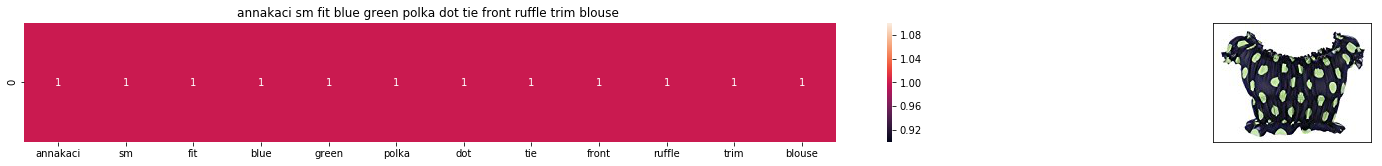

ASIN : B00KLHUIBS
Brand: Anna-Kaci
Title: annakaci sm fit blue green polka dot tie front ruffle trim blouse 
Euclidean similarity with the query image : 0.0


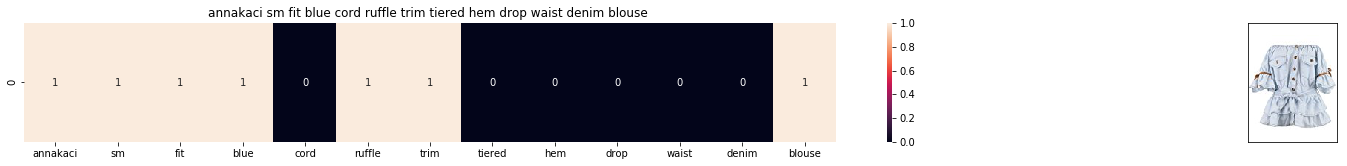

ASIN : B0759G15ZX
Brand: Anna-Kaci
Title: annakaci sm fit blue cord ruffle trim tiered hem drop waist denim blouse 
Euclidean similarity with the query image : 3.3166247903554


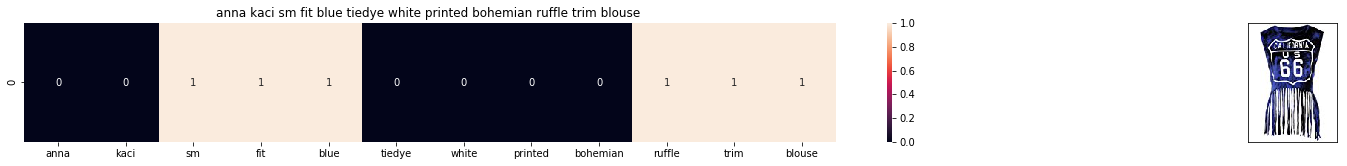

ASIN : B00YQ8S4K0
Brand: Anna-Kaci
Title: anna kaci sm fit blue tiedye white printed bohemian ruffle trim blouse 
Euclidean similarity with the query image : 3.4641016151377544


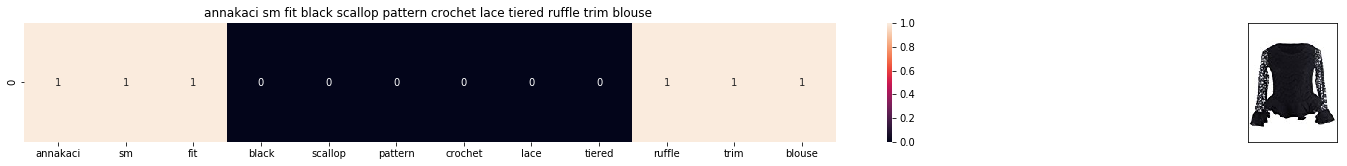

ASIN : B00O194W8W
Brand: Anna-Kaci
Title: annakaci sm fit black scallop pattern crochet lace tiered ruffle trim blouse 
Euclidean similarity with the query image : 3.4641016151377544


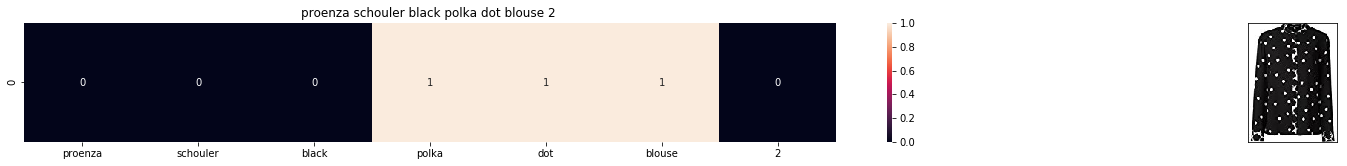

ASIN : B074TLHLMN
Brand: Proenza Schouler
Title: proenza schouler black polka dot blouse 2 
Euclidean similarity with the query image : 3.4641016151377544


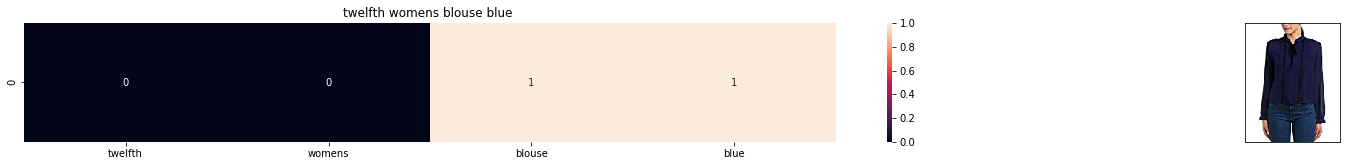

ASIN : B074F5BP5F
Brand: On Twelfth
Title: twelfth womens blouse blue 
Euclidean similarity with the query image : 3.4641016151377544


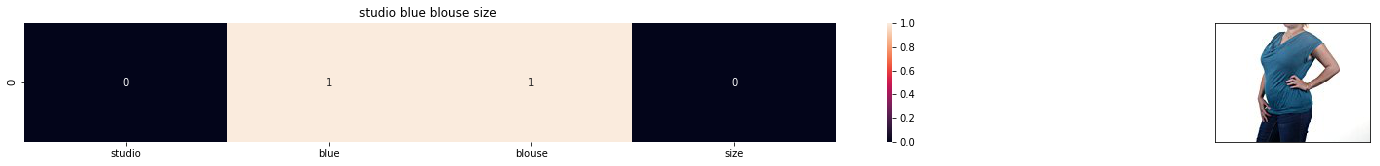

ASIN : B016P80OKQ
Brand: Studio M
Title: studio blue blouse size 
Euclidean similarity with the query image : 3.4641016151377544


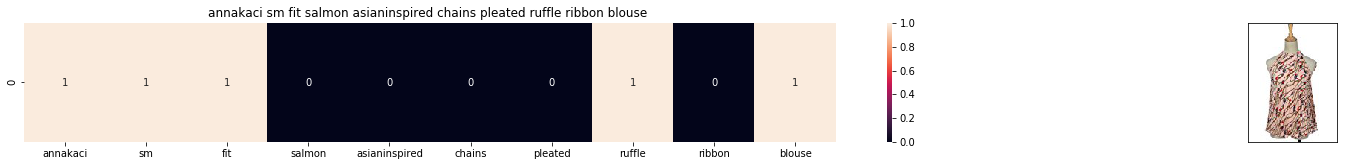

ASIN : B007KSG42S
Brand: Anna-Kaci
Title: annakaci sm fit salmon asianinspired chains pleated ruffle ribbon blouse 
Euclidean similarity with the query image : 3.4641016151377544


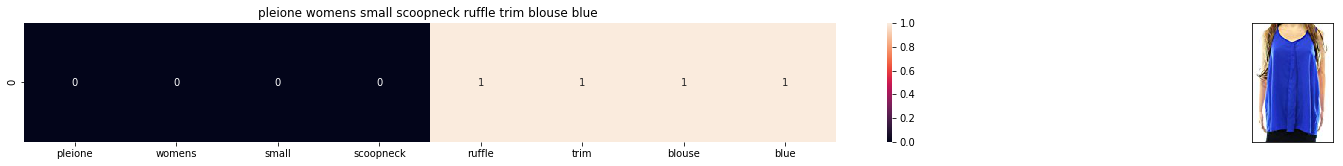

ASIN : B072VHTT1D
Brand: Pleione
Title: pleione womens small scoopneck ruffle trim blouse blue 
Euclidean similarity with the query image : 3.4641016151377544


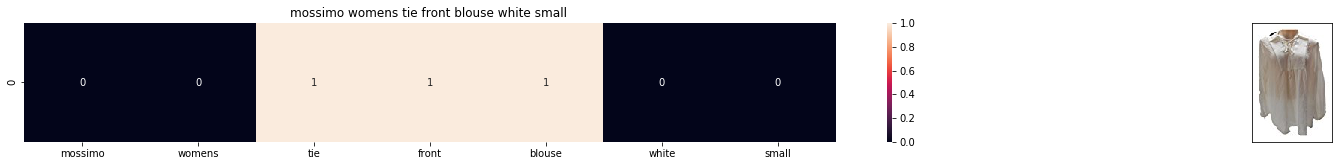

ASIN : B07111HHX6
Brand: Mossimo
Title: mossimo womens tie front blouse white small 
Euclidean similarity with the query image : 3.605551275463989


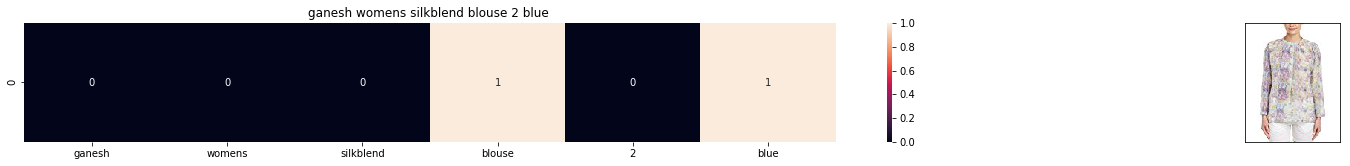

ASIN : B01N3SAT1F
Brand: Ganesh
Title: ganesh womens silkblend blouse 2 blue 
Euclidean similarity with the query image : 3.605551275463989


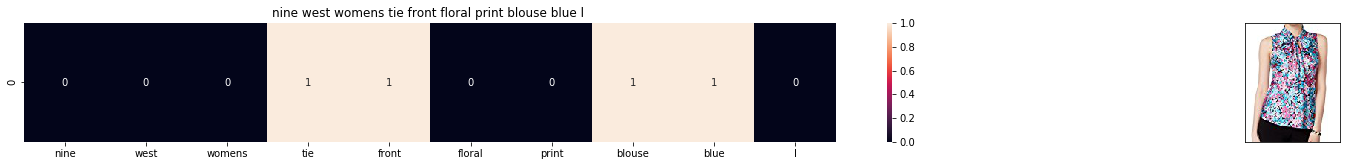

ASIN : B06WW5C6NJ
Brand: Nine West
Title: nine west womens tie front floral print blouse blue l 
Euclidean similarity with the query image : 3.605551275463989


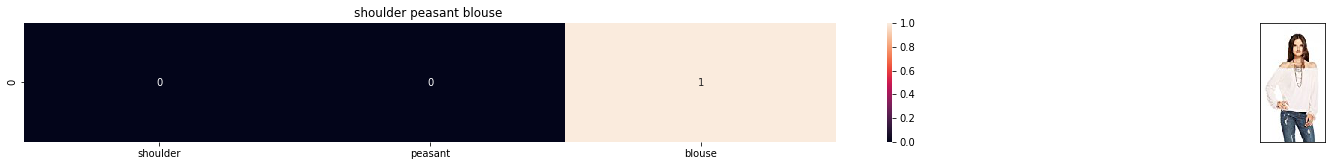

ASIN : B01E1QD5PK
Brand: CHASER
Title: shoulder peasant blouse 
Euclidean similarity with the query image : 3.605551275463989


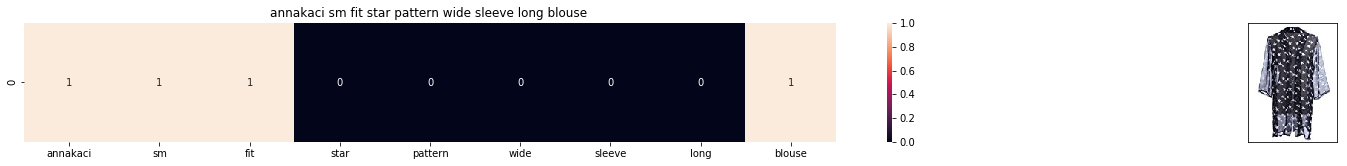

ASIN : B00G5RYY18
Brand: Anna-Kaci
Title: annakaci sm fit star pattern wide sleeve long blouse 
Euclidean similarity with the query image : 3.605551275463989


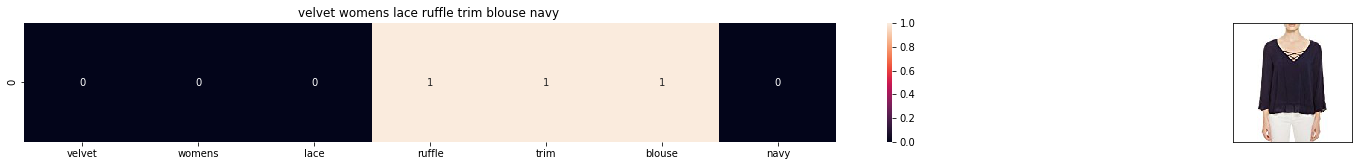

ASIN : B06XCZGQLP
Brand: Velvet by Graham & Spencer
Title: velvet womens lace ruffle trim blouse navy 
Euclidean similarity with the query image : 3.605551275463989


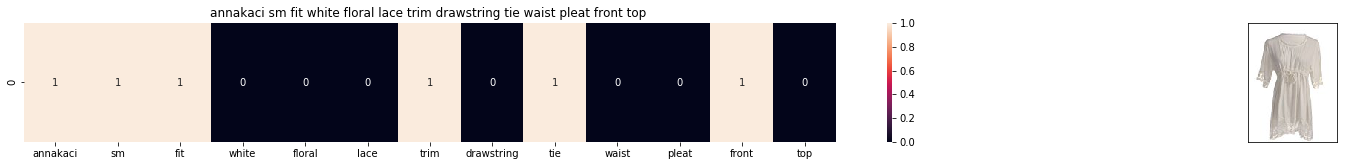

ASIN : B00DW1NKSS
Brand: Anna-Kaci
Title: annakaci sm fit white floral lace trim drawstring tie waist pleat front top 
Euclidean similarity with the query image : 3.605551275463989


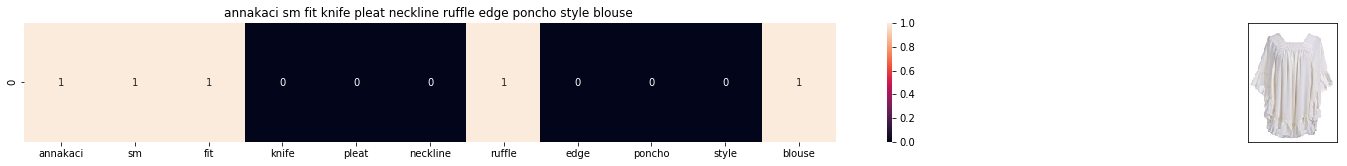

ASIN : B00HCNNOJW
Brand: Anna-Kaci
Title: annakaci sm fit knife pleat neckline ruffle edge poncho style blouse 
Euclidean similarity with the query image : 3.605551275463989


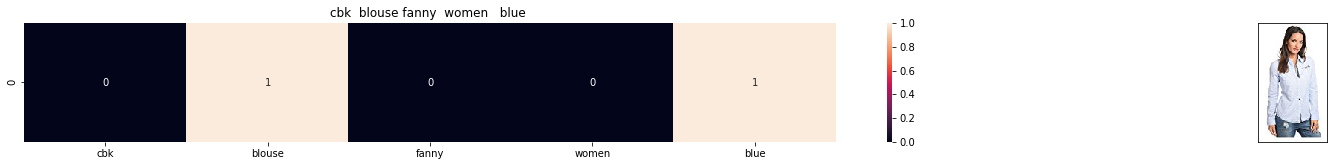

ASIN : B071NDX99J
Brand: CBK
Title: cbk  blouse fanny  women   blue 
Euclidean similarity with the query image : 3.605551275463989


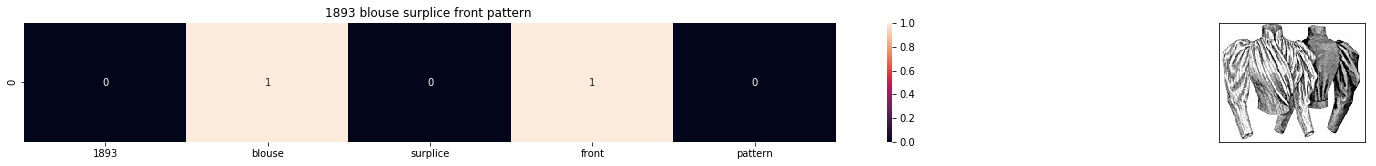

ASIN : B00886YXL0
Brand: Ageless Patterns
Title: 1893 blouse surplice front pattern 
Euclidean similarity with the query image : 3.605551275463989


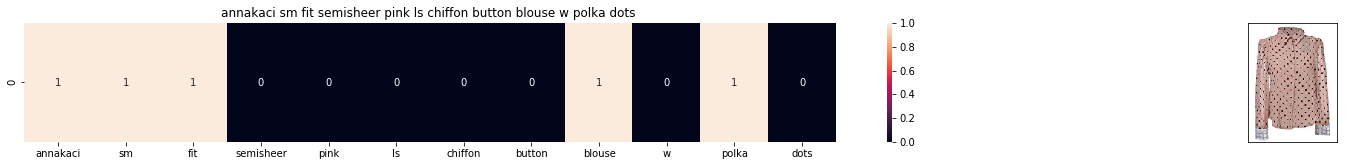

ASIN : B008Z5ST3C
Brand: Anna-Kaci
Title: annakaci sm fit semisheer pink ls chiffon button blouse w polka dots 
Euclidean similarity with the query image : 3.605551275463989


In [85]:
def bag_of_words_model(doc_id, num_results):
 
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
  
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
    
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

bag_of_words_model(931, 20) 

In [86]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

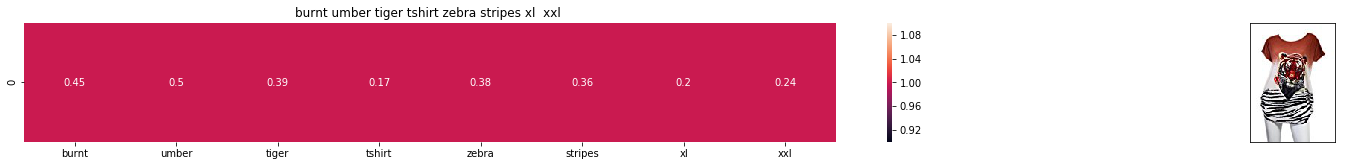

ASIN : B00JXQB5FQ
BRAND : Si Row
Eucliden distance from the given image : 0.0


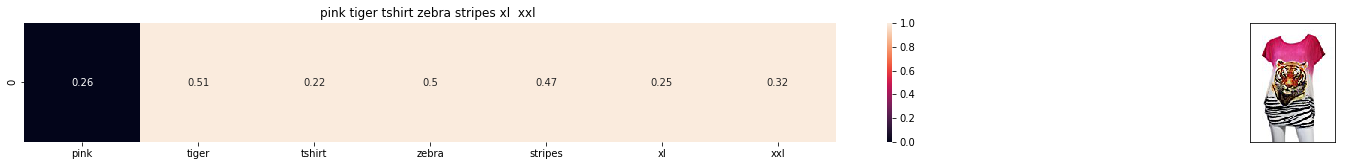

ASIN : B00JXQASS6
BRAND : Si Row
Eucliden distance from the given image : 0.7536331912451361


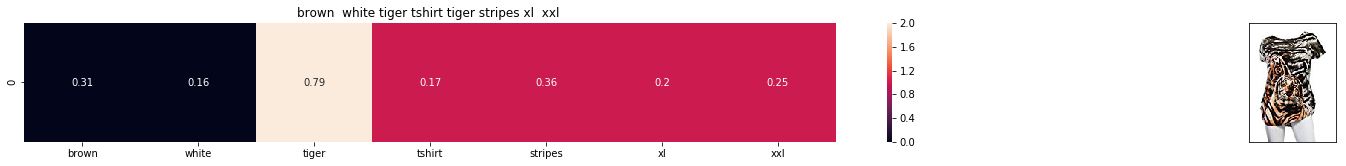

ASIN : B00JXQCWTO
BRAND : Si Row
Eucliden distance from the given image : 0.9357643943769645


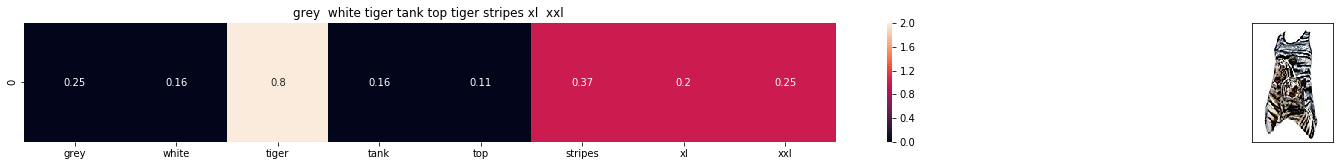

ASIN : B00JXQAFZ2
BRAND : Si Row
Eucliden distance from the given image : 0.9586153524200749


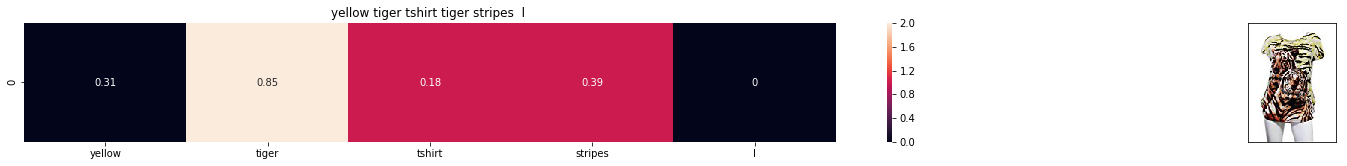

ASIN : B00JXQCUIC
BRAND : Si Row
Eucliden distance from the given image : 1.000074961446881


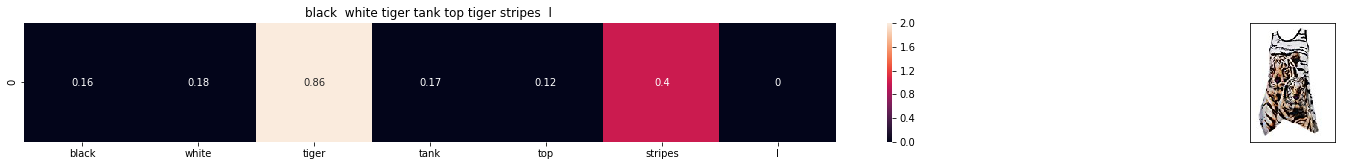

ASIN : B00JXQAO94
BRAND : Si Row
Eucliden distance from the given image : 1.023215552457452


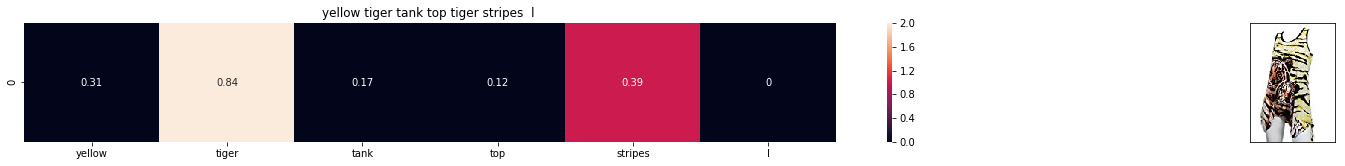

ASIN : B00JXQAUWA
BRAND : Si Row
Eucliden distance from the given image : 1.031991846303421


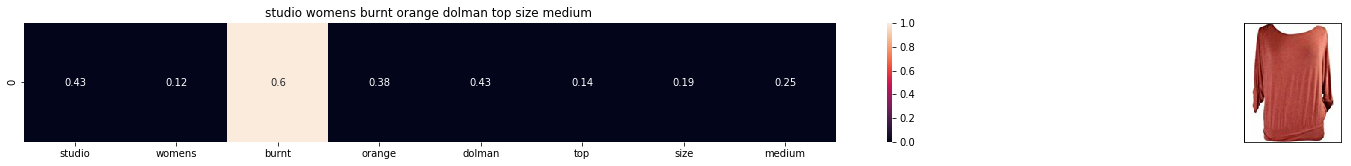

ASIN : B06XSCVFT5
BRAND : Studio M
Eucliden distance from the given image : 1.2106843670424716


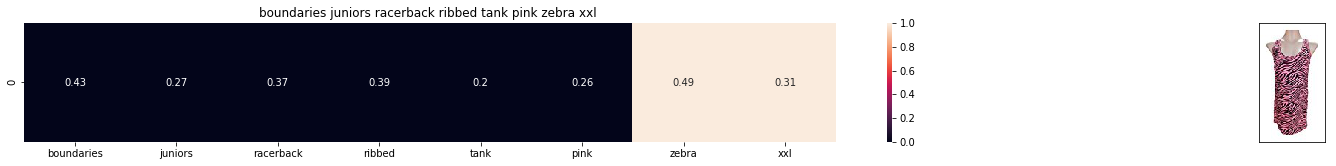

ASIN : B06Y2GTYPM
BRAND : No Boundaries
Eucliden distance from the given image : 1.212168381072083


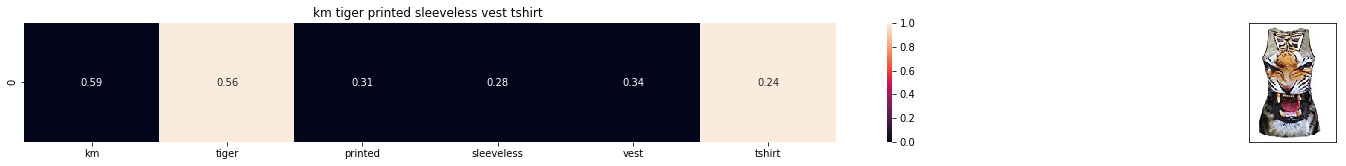

ASIN : B012VQLT6Y
BRAND : KM T-shirt
Eucliden distance from the given image : 1.219790640280982


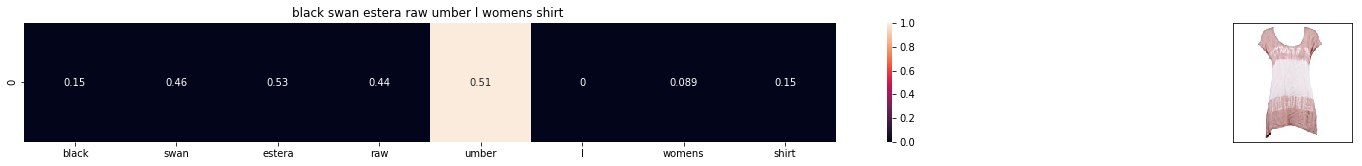

ASIN : B06Y1VN8WQ
BRAND : Black Swan
Eucliden distance from the given image : 1.2206849659998316


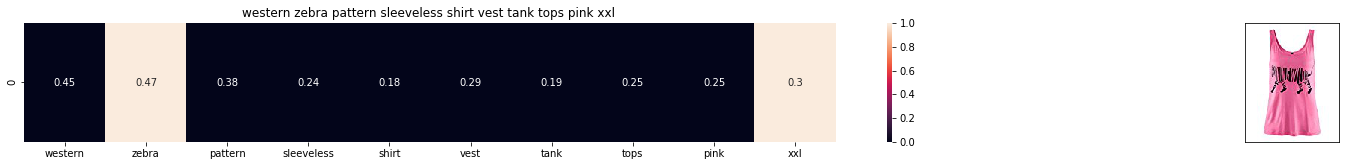

ASIN : B00Z6HEXWI
BRAND : Black Temptation
Eucliden distance from the given image : 1.221281392120943


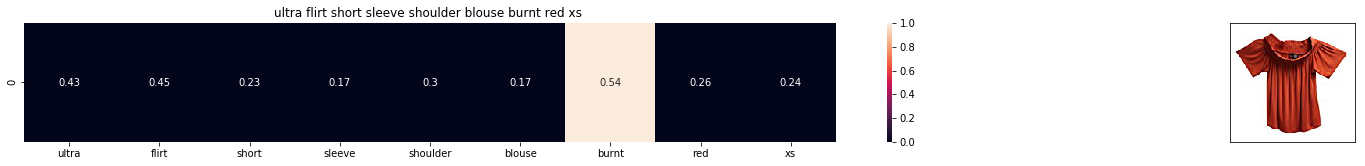

ASIN : B074TR12BH
BRAND : Ultra Flirt
Eucliden distance from the given image : 1.2313364094597743


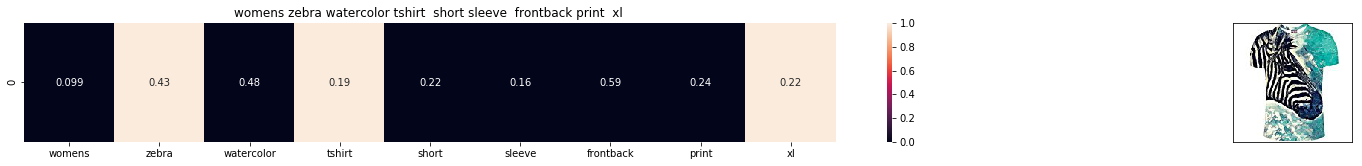

ASIN : B072R2JXKW
BRAND : WHAT ON EARTH
Eucliden distance from the given image : 1.2318451972624518


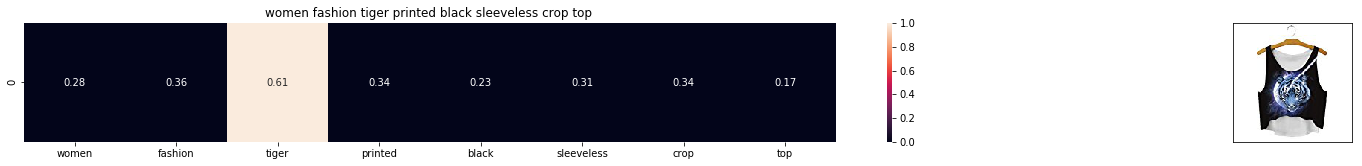

ASIN : B074T8ZYGX
BRAND : MKP Crop Top
Eucliden distance from the given image : 1.2340607457359425


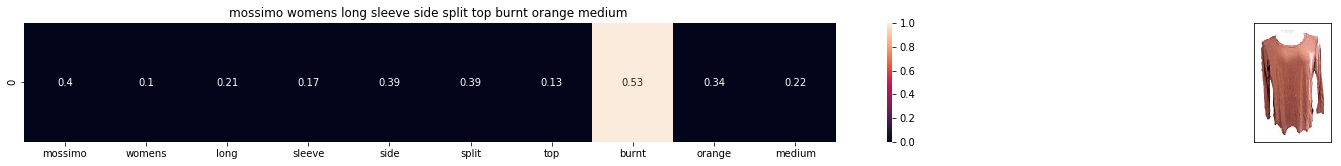

ASIN : B071ZDF6T2
BRAND : Mossimo
Eucliden distance from the given image : 1.2352785577664824


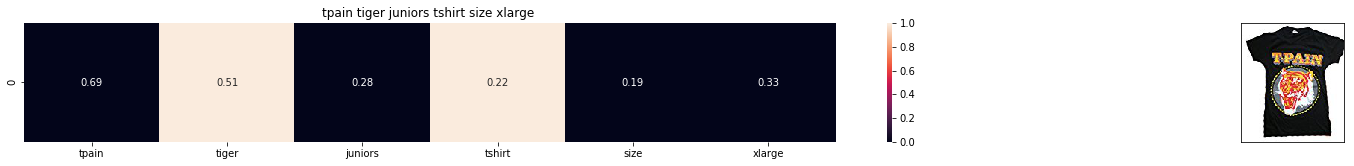

ASIN : B01K0H02OG
BRAND : Tultex
Eucliden distance from the given image : 1.236457298812782


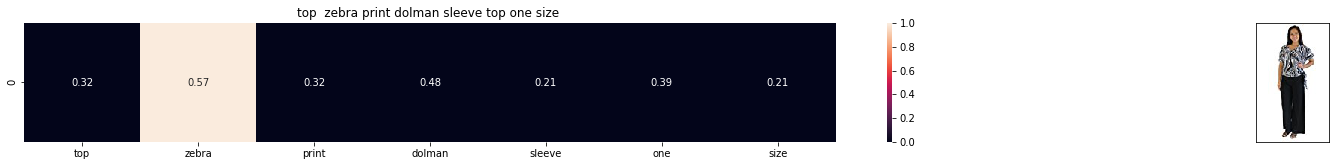

ASIN : B00H8A6ZLI
BRAND : Vivian's Fashions
Eucliden distance from the given image : 1.24996155052848


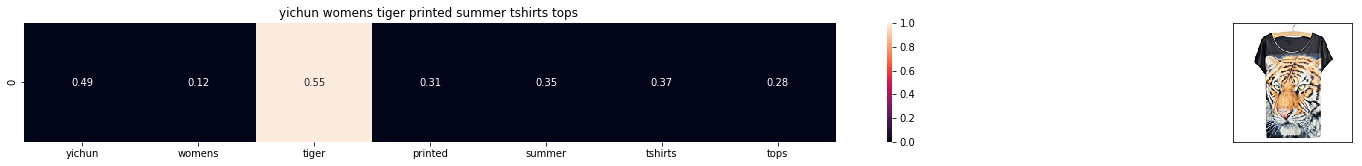

ASIN : B010NN9RXO
BRAND : YICHUN
Eucliden distance from the given image : 1.25354614208561


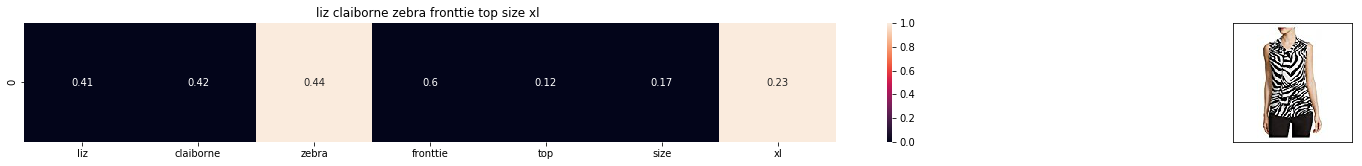

ASIN : B06XBY5QXL
BRAND : Liz Claiborne
Eucliden distance from the given image : 1.2538832938357722


In [87]:
def tfidf_model(doc_id, num_results):
   
    
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

   
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
   
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
       
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(12566, 20)

In [88]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

In [89]:
def n_containing(word):
    return sum(1 for blob in data['title'] if word in blob.split())

In [96]:

def idf(word):

    return math.log(data.shape[0] / (n_containing(word)))

In [97]:
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
   
    idf_val = idf(i)
    
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val

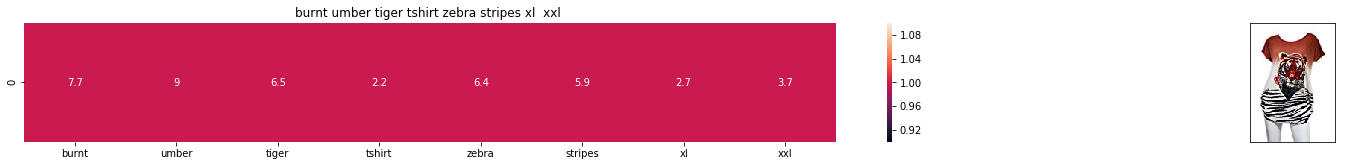

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from the given image : 0.0


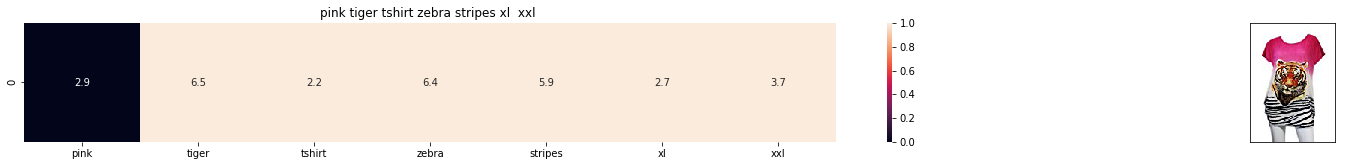

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from the given image : 12.20507131122177


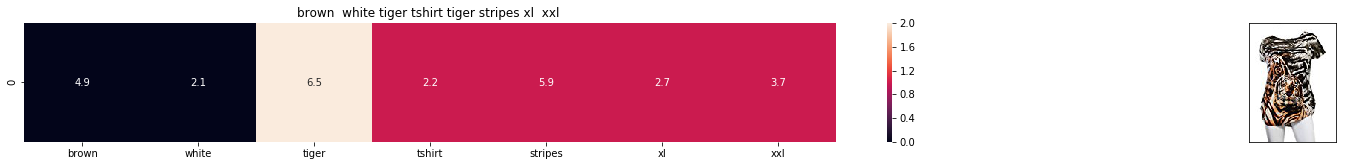

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from the given image : 14.468362685603465


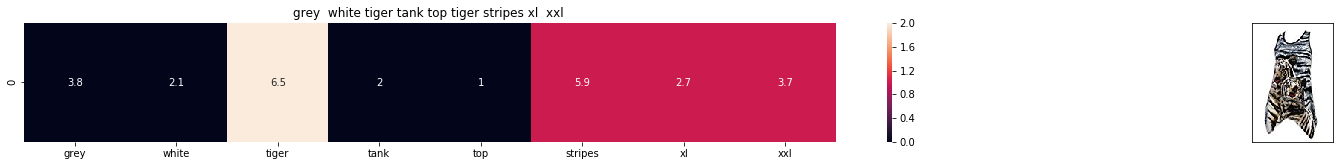

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from the given image : 14.486832924778964


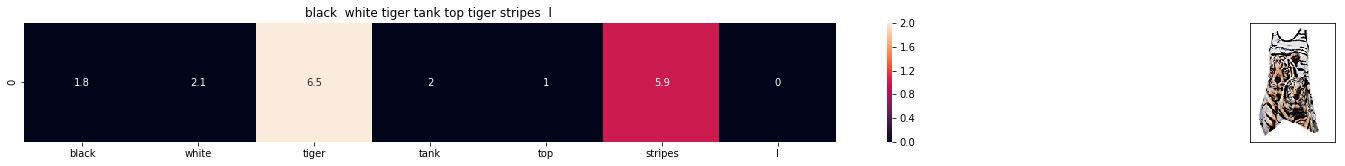

ASIN : B00JXQAO94
Brand : Si Row
euclidean distance from the given image : 14.833392966672909


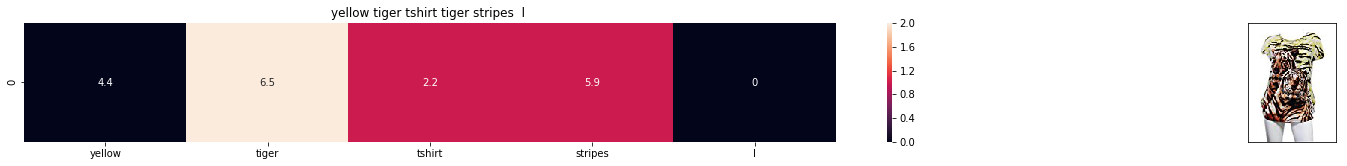

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from the given image : 14.898744516719225


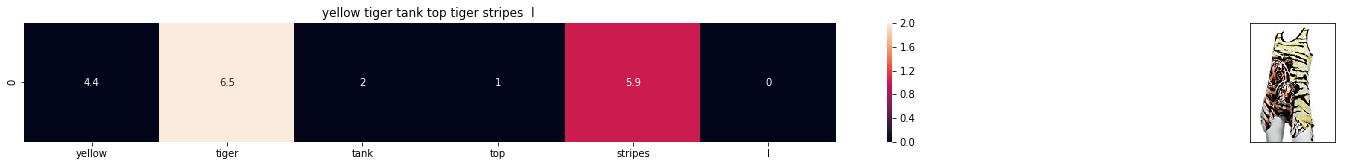

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from the given image : 15.224458287343769


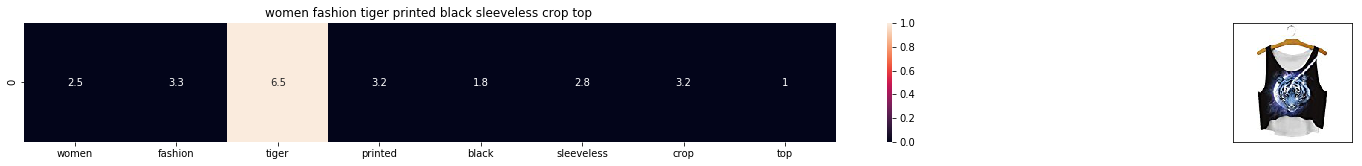

ASIN : B074T8ZYGX
Brand : MKP Crop Top
euclidean distance from the given image : 17.080812955631995


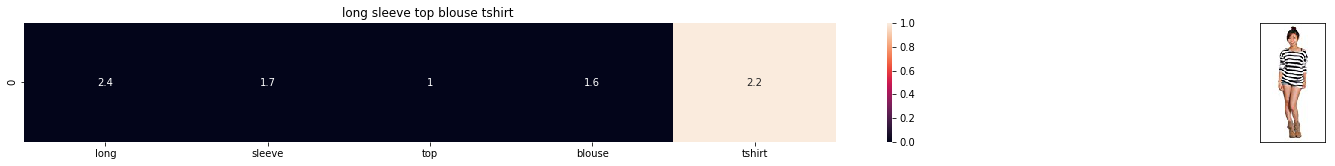

ASIN : B00KF2N5PU
Brand : Vietsbay
euclidean distance from the given image : 17.090168125645416


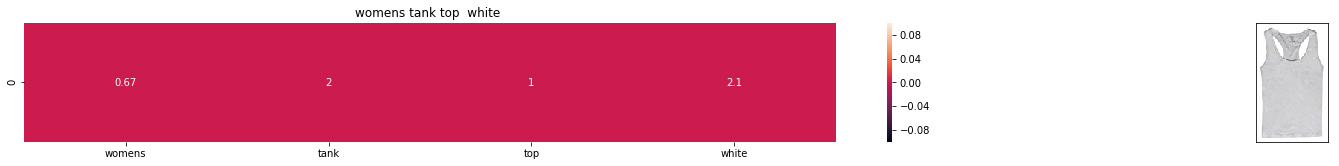

ASIN : B00JPOZ9GM
Brand : Sofra
euclidean distance from the given image : 17.153215337562703


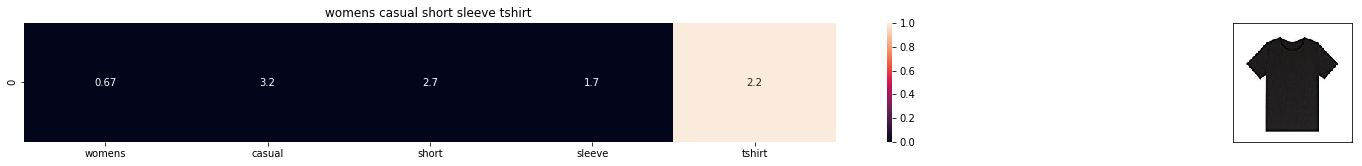

ASIN : B074T9KG9Q
Brand : Rain
euclidean distance from the given image : 17.33671523874989


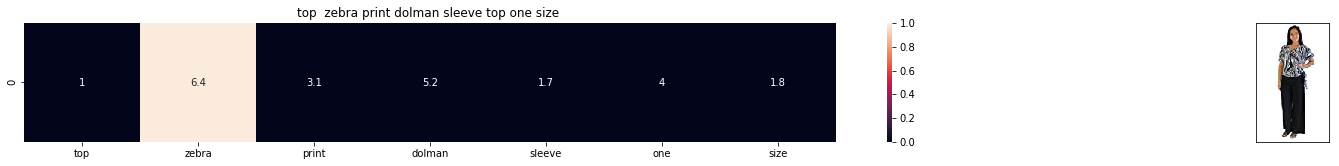

ASIN : B00H8A6ZLI
Brand : Vivian's Fashions
euclidean distance from the given image : 17.410075941001253


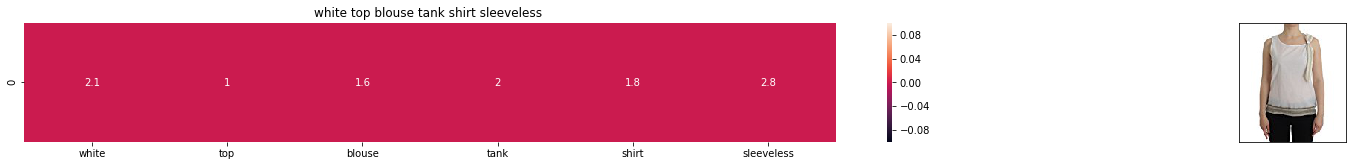

ASIN : B074G5G5RK
Brand : ERMANNO SCERVINO
euclidean distance from the given image : 17.539921335459557


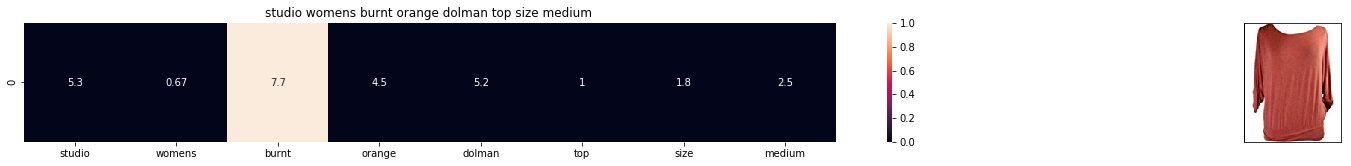

ASIN : B06XSCVFT5
Brand : Studio M
euclidean distance from the given image : 17.61275854366134


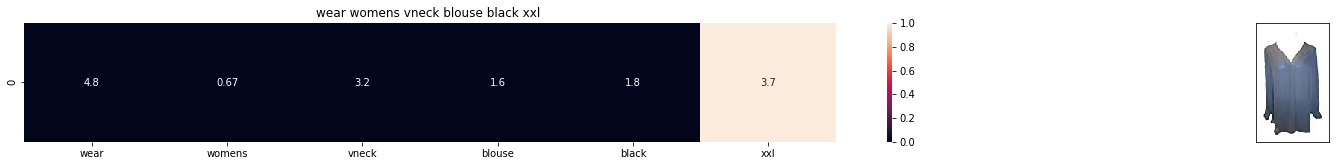

ASIN : B06Y6FH453
Brand : Who What Wear
euclidean distance from the given image : 17.623745282500135


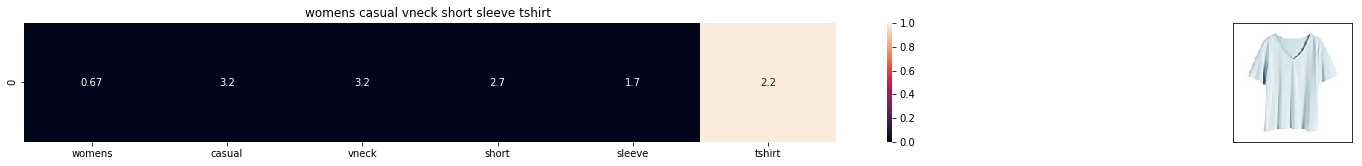

ASIN : B074V45DCX
Brand : Rain
euclidean distance from the given image : 17.634342496835046


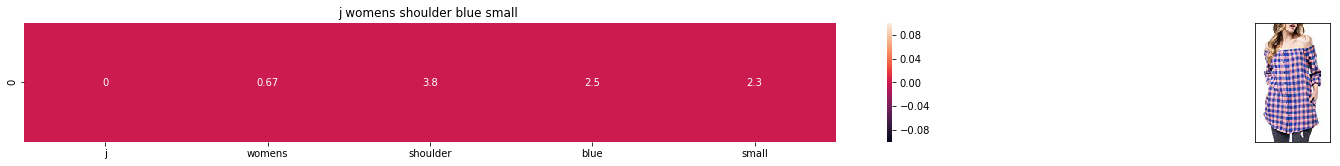

ASIN : B07583CQFT
Brand : Very J
euclidean distance from the given image : 17.63753712743611


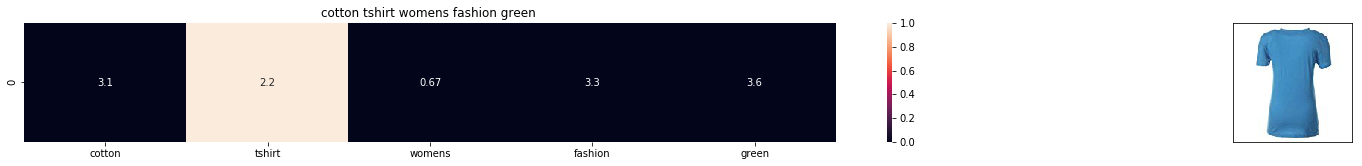

ASIN : B073GJGVBN
Brand : Ivan Levi
euclidean distance from the given image : 17.7230738913371


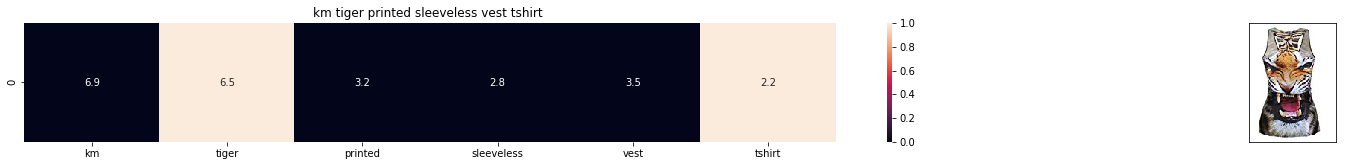

ASIN : B012VQLT6Y
Brand : KM T-shirt
euclidean distance from the given image : 17.762588561202364


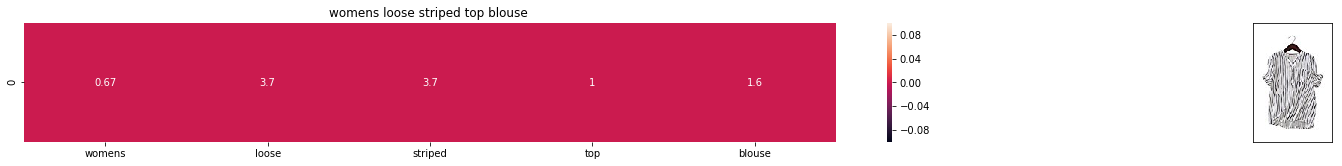

ASIN : B00ZZMYBRG
Brand : HP-LEISURE
euclidean distance from the given image : 17.779536864674238


In [98]:
def idf_model(doc_id, num_results):
    
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)

        
        
idf_model(12566,20)

In [99]:
import pickle

with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)


In [100]:


def get_word_vec(sentence, doc_id, m_name):
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            vec.append(np.zeros(shape=(300,)))
    return  np.array(vec)

def get_distance(vec1, vec2):
    
    final_dist = []
    for i in vec1:
        dist = []
        for j in vec2:
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    ax.set_xticklabels(sentence2.split())
    ax.set_yticklabels(sentence1.split())
    
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [101]:


vocab = model.keys()

def build_avg_vec(sentence, num_features, doc_id, m_name):

    featureVec = np.zeros((num_features,), dtype="float32")
 
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [102]:
w2v_title = []
doc_id = 0

for i in data['title']:
    w2v_title.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1
w2v_title = np.array(w2v_title)

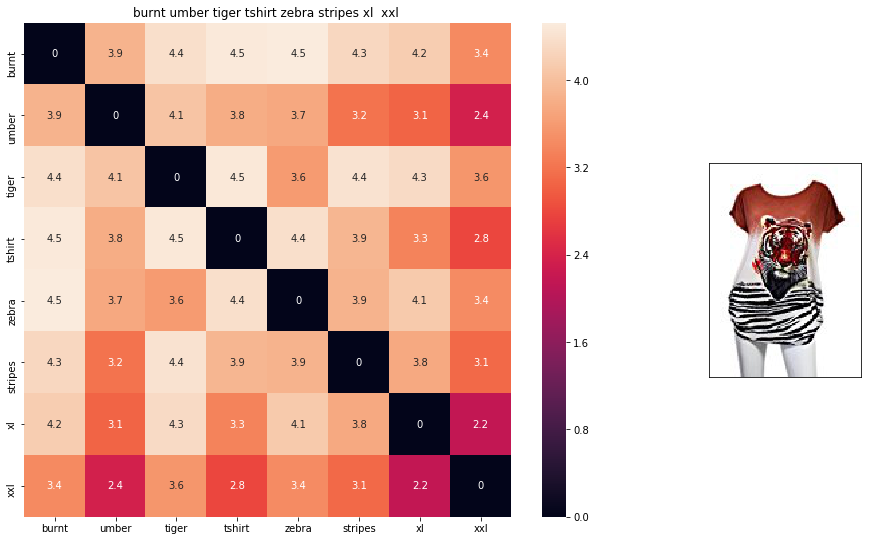

ASIN : B00JXQB5FQ
BRAND : Si Row
euclidean distance from given input image : 0.00069053395


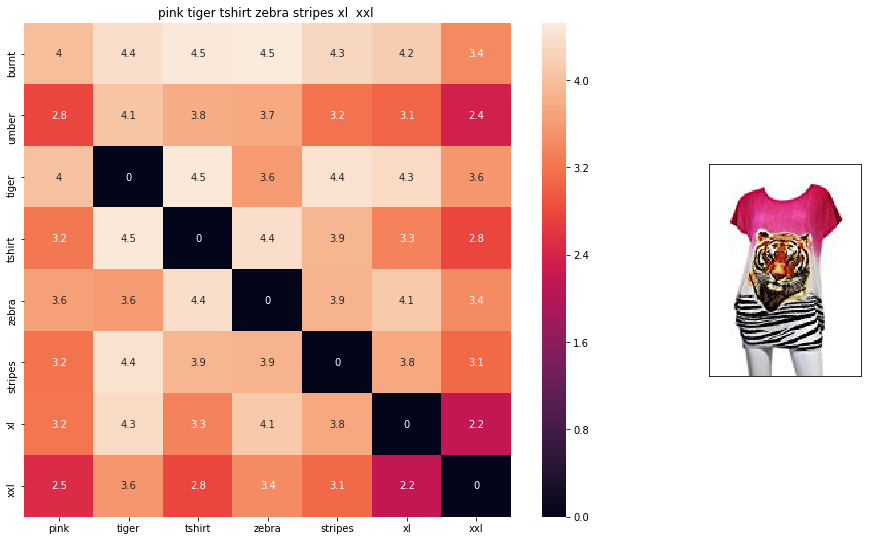

ASIN : B00JXQASS6
BRAND : Si Row
euclidean distance from given input image : 0.5891932


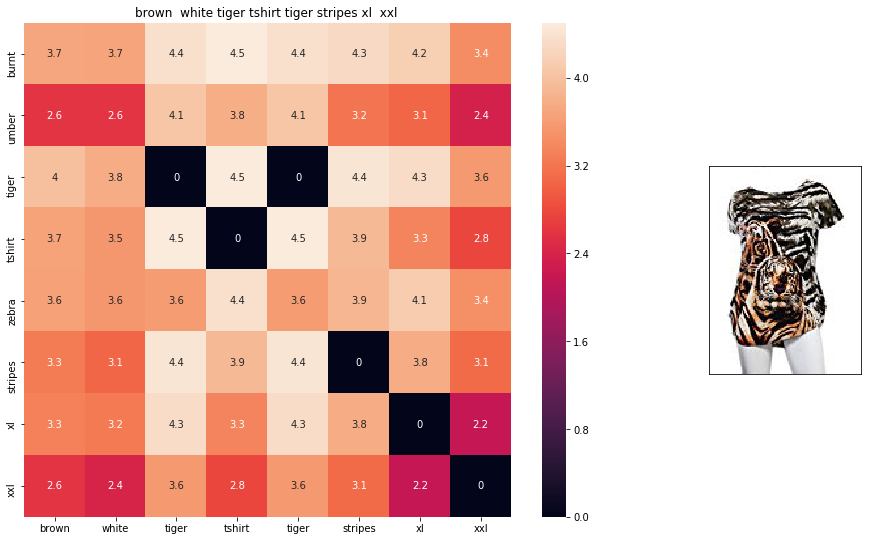

ASIN : B00JXQCWTO
BRAND : Si Row
euclidean distance from given input image : 0.7003439


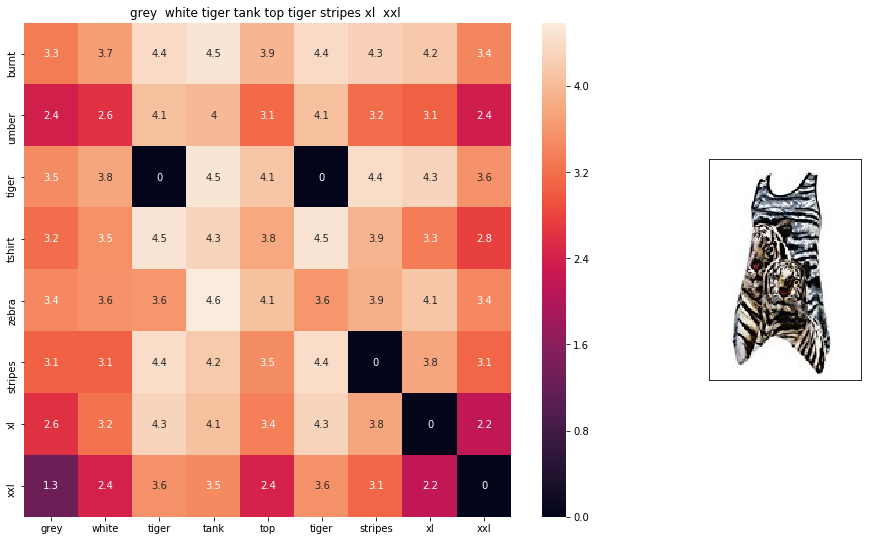

ASIN : B00JXQAFZ2
BRAND : Si Row
euclidean distance from given input image : 0.8928398


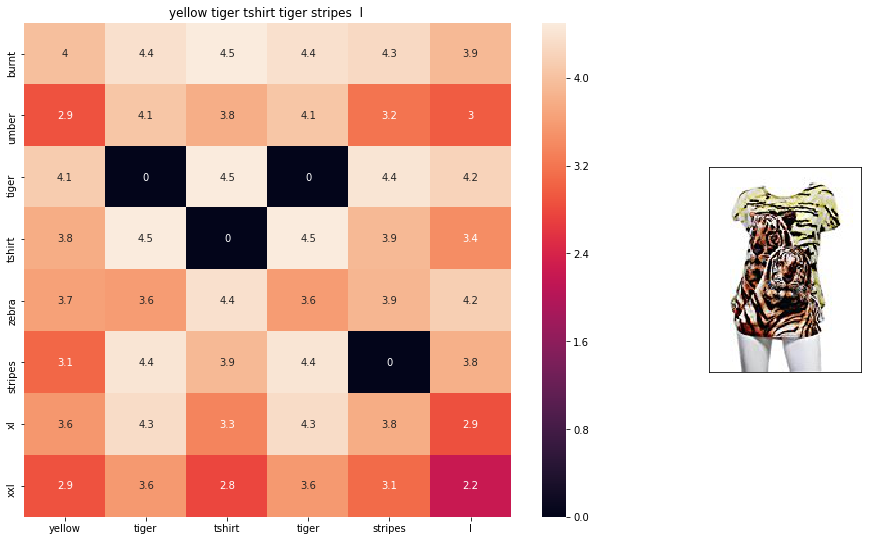

ASIN : B00JXQCUIC
BRAND : Si Row
euclidean distance from given input image : 0.95601267


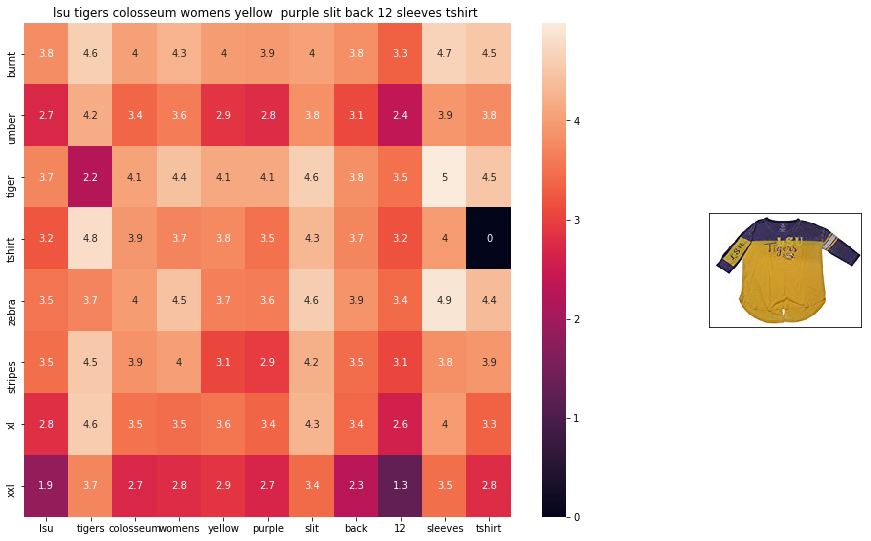

ASIN : B073R5Q8HD
BRAND : Colosseum
euclidean distance from given input image : 1.0229691


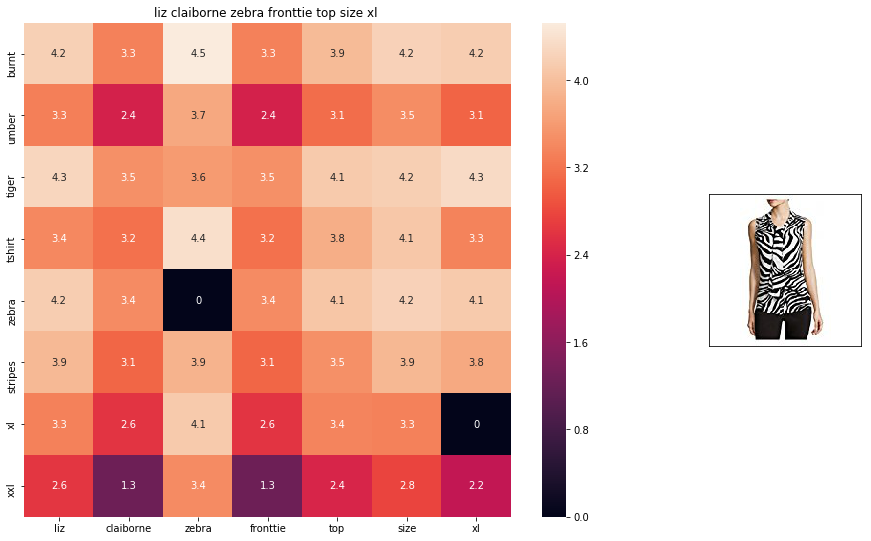

ASIN : B06XBY5QXL
BRAND : Liz Claiborne
euclidean distance from given input image : 1.0669324


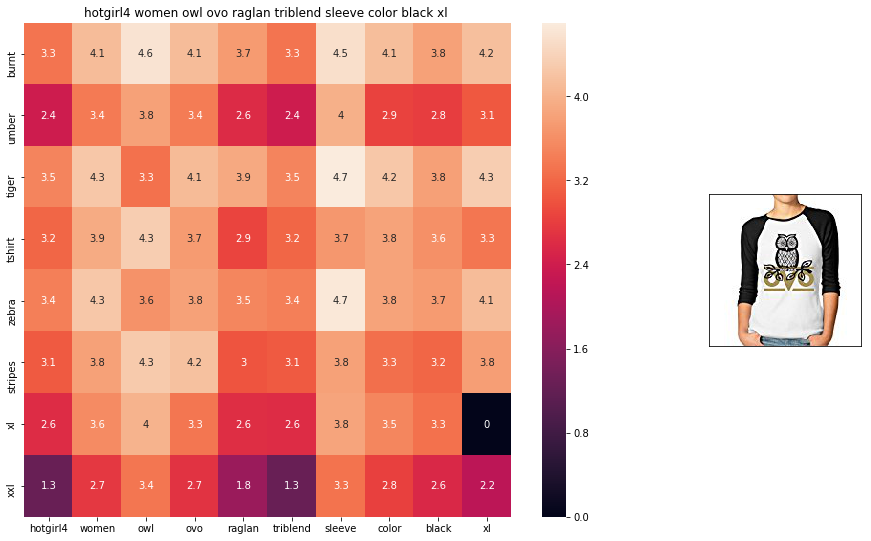

ASIN : B01L8L73M2
BRAND : Hotgirl4 Raglan Design
euclidean distance from given input image : 1.0731405


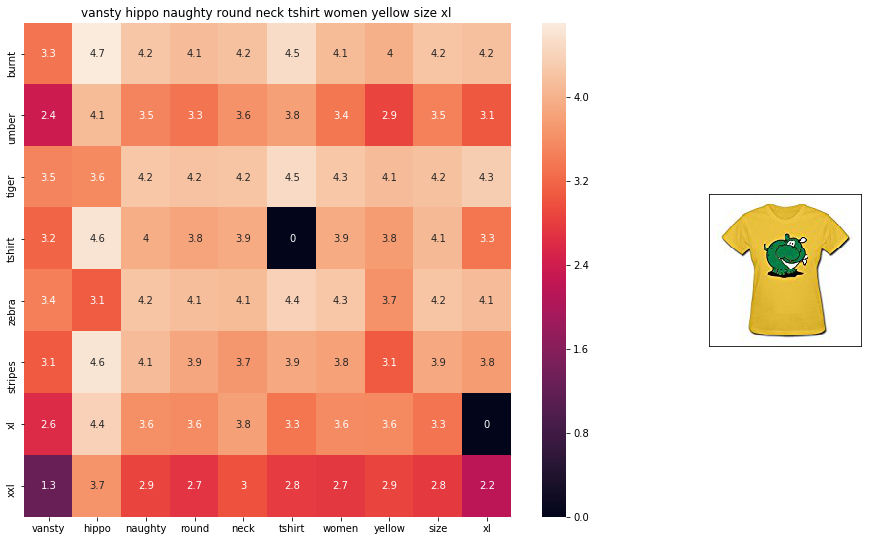

ASIN : B01EJS5H06
BRAND : Vansty
euclidean distance from given input image : 1.075719


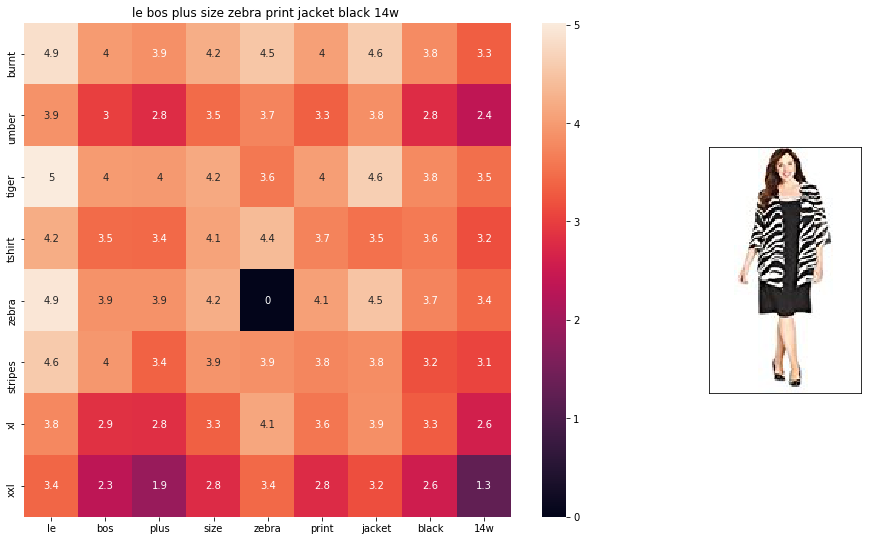

ASIN : B01BO1XRK8
BRAND : Le Bos
euclidean distance from given input image : 1.0839964


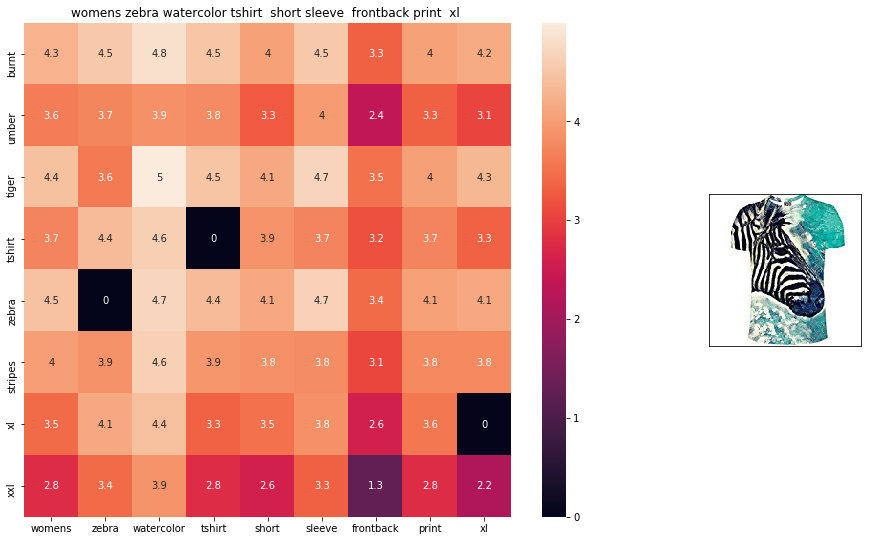

ASIN : B072R2JXKW
BRAND : WHAT ON EARTH
euclidean distance from given input image : 1.0842218


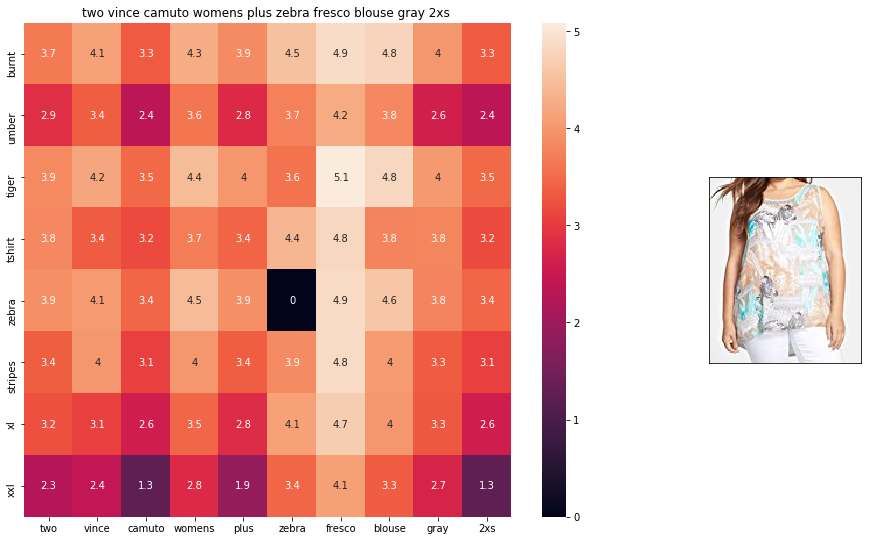

ASIN : B074MJRGW6
BRAND : Two by Vince Camuto
euclidean distance from given input image : 1.0895038


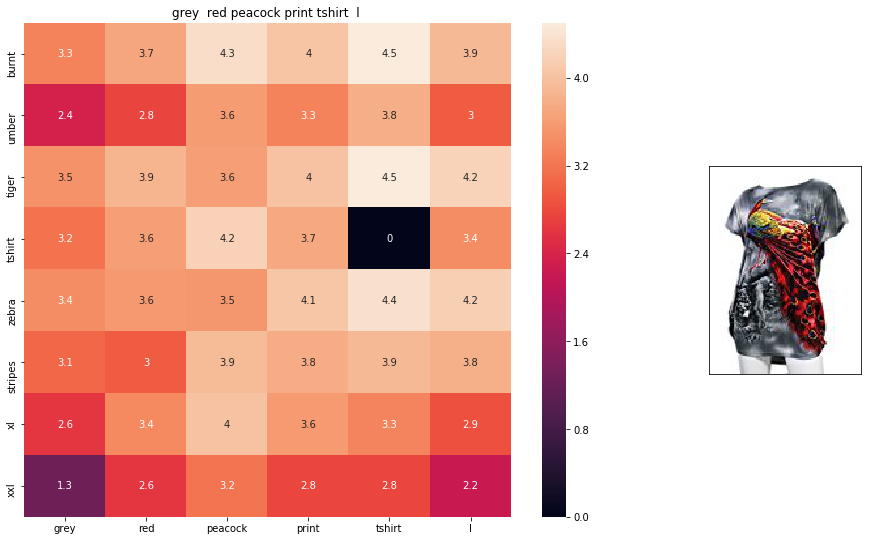

ASIN : B00JXQCFRS
BRAND : Si Row
euclidean distance from given input image : 1.0900588


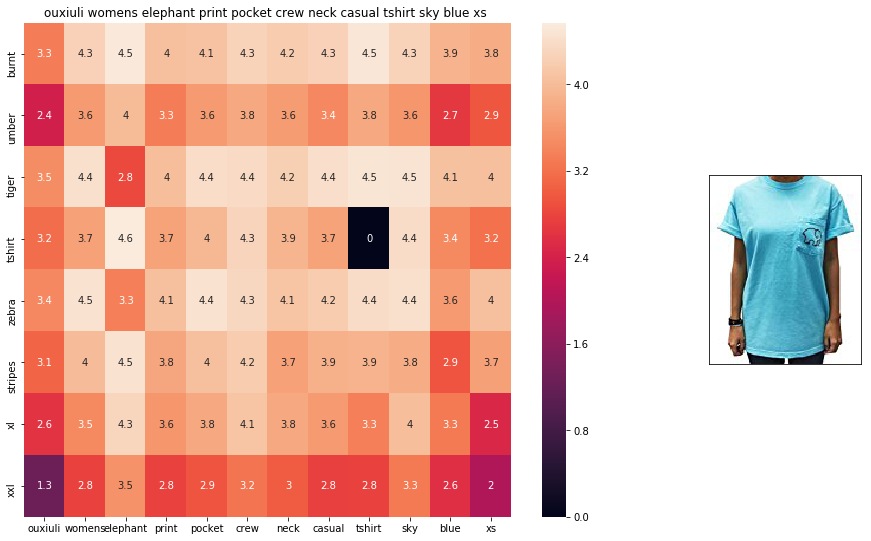

ASIN : B01I53HU6K
BRAND : ouxiuli
euclidean distance from given input image : 1.0920112


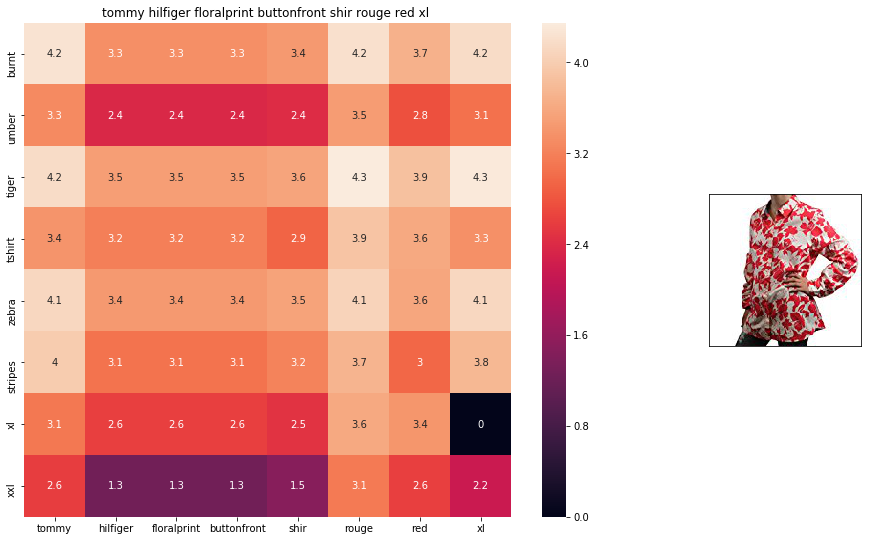

ASIN : B0711NGTQM
BRAND : THILFIGER RTW
euclidean distance from given input image : 1.0923418


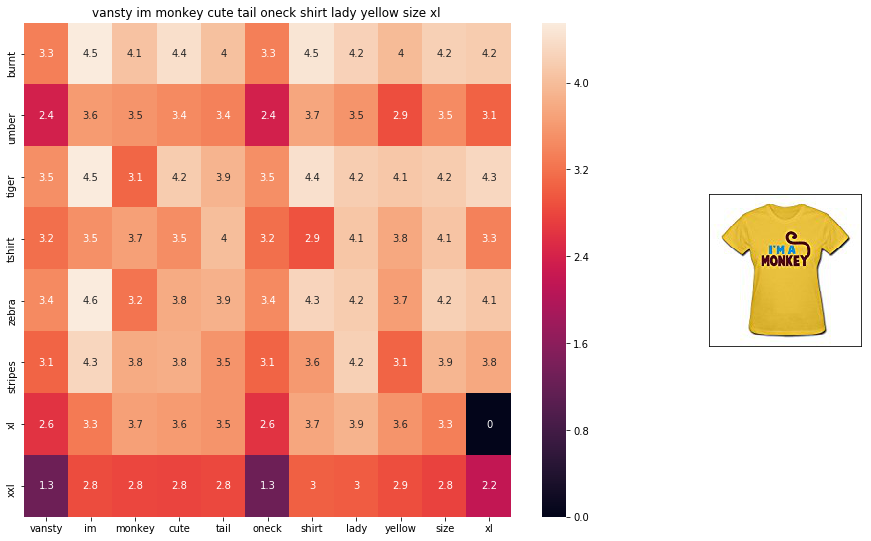

ASIN : B01EFSLO8Y
BRAND : Vansty
euclidean distance from given input image : 1.0934006


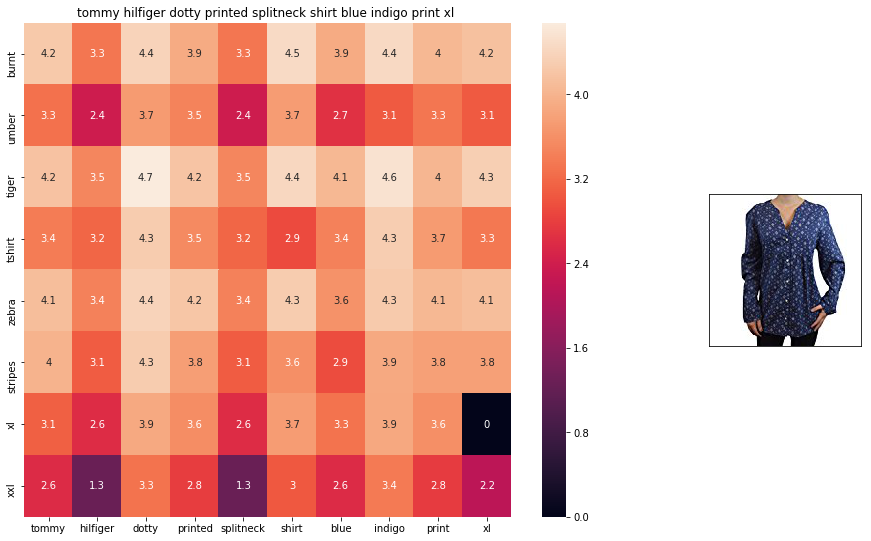

ASIN : B0716TVWQ4
BRAND : THILFIGER RTW
euclidean distance from given input image : 1.0942026


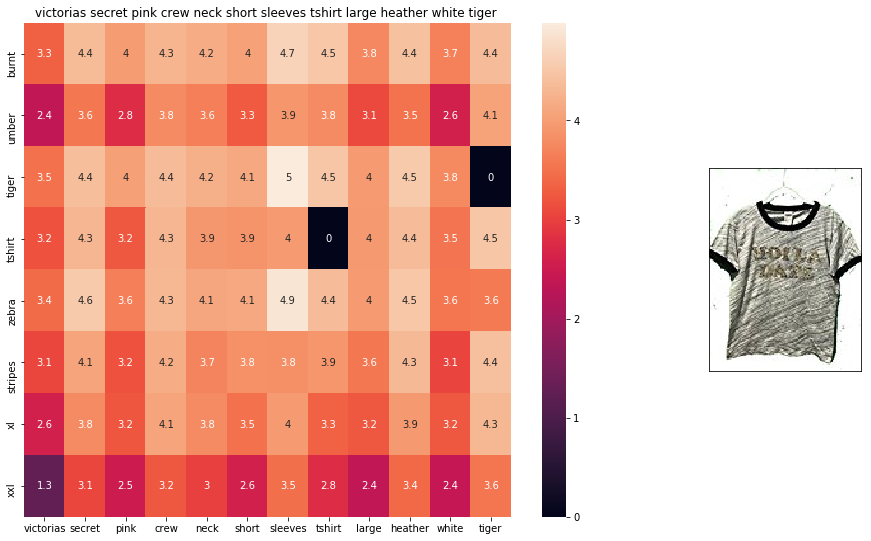

ASIN : B0716MVPGV
BRAND : V.Secret
euclidean distance from given input image : 1.0948305


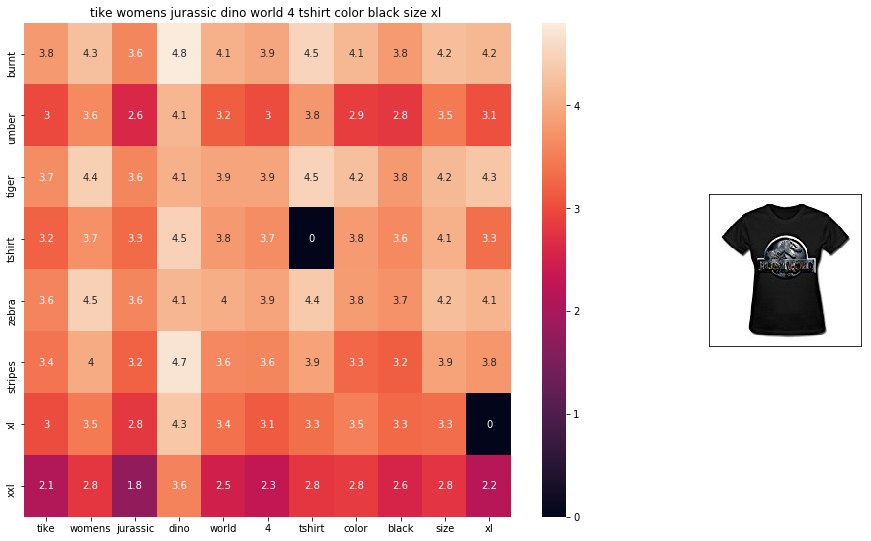

ASIN : B016OPN4OI
BRAND : TIKE Fashions
euclidean distance from given input image : 1.0951275


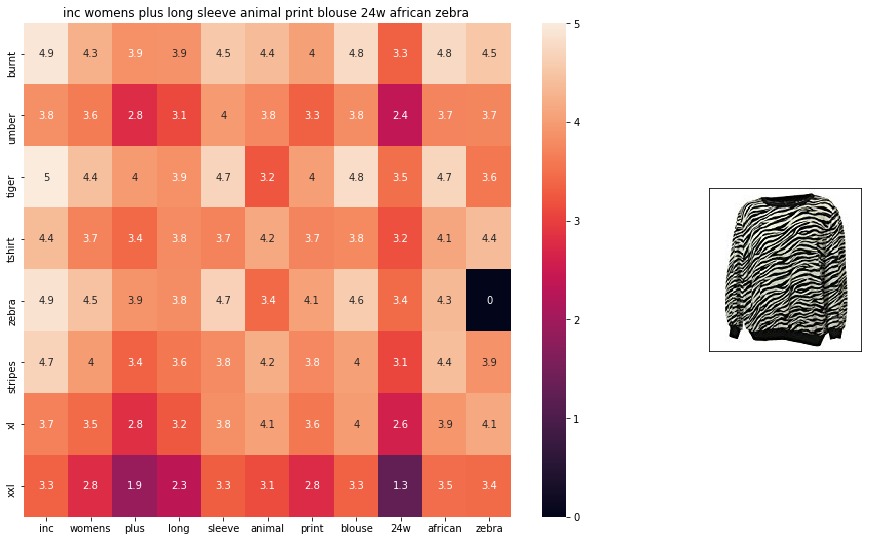

ASIN : B018WDJCUA
BRAND : INC - International Concepts Woman
euclidean distance from given input image : 1.0966892


In [103]:
def avg_w2v_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(w2v_title, w2v_title[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'avg')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from given input image :', pdists[i])
        print('='*125)

        
avg_w2v_model(12566, 20)

In [104]:
doc_id = 0
w2v_title_weight = []
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
w2v_title_weight = np.array(w2v_title_weight)

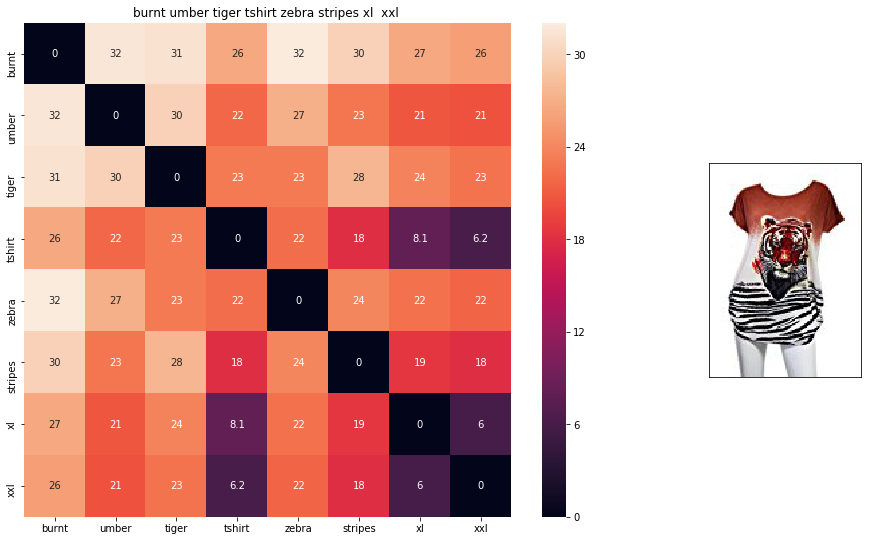

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.00390625


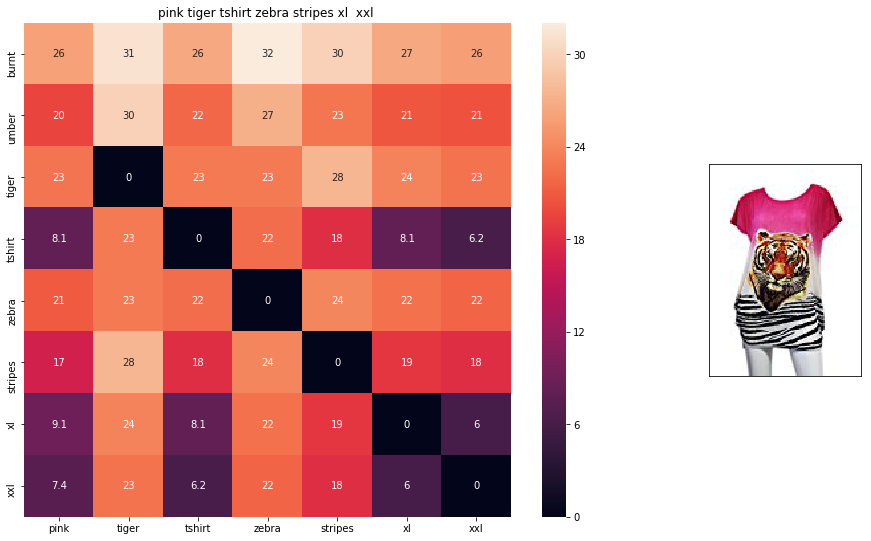

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from input : 4.0638885


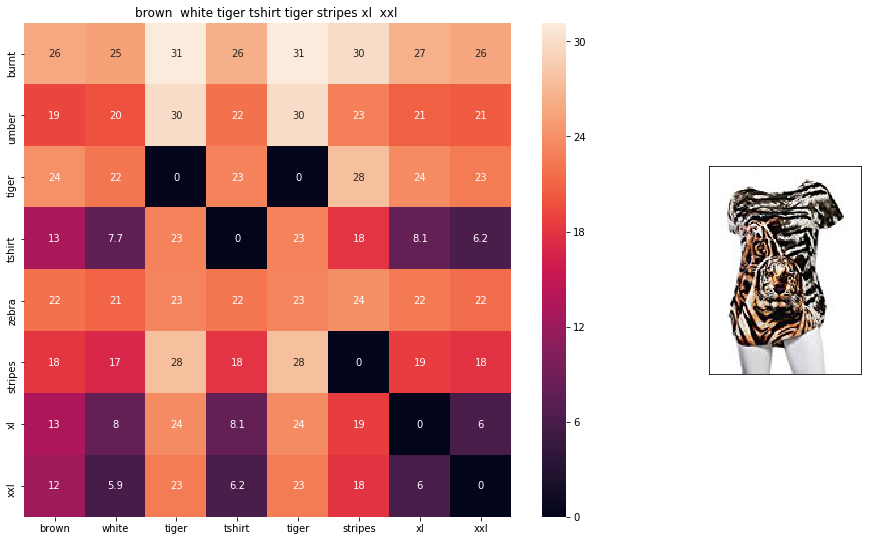

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from input : 4.770942


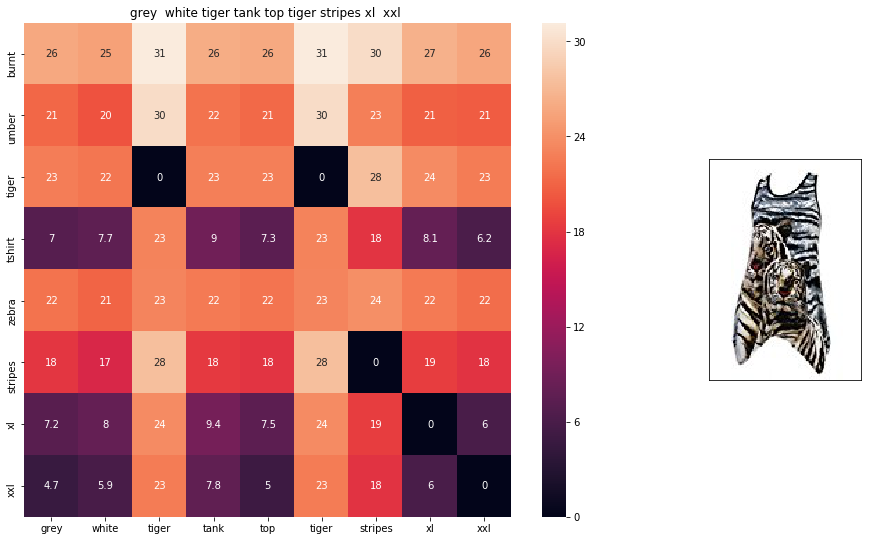

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from input : 5.360161


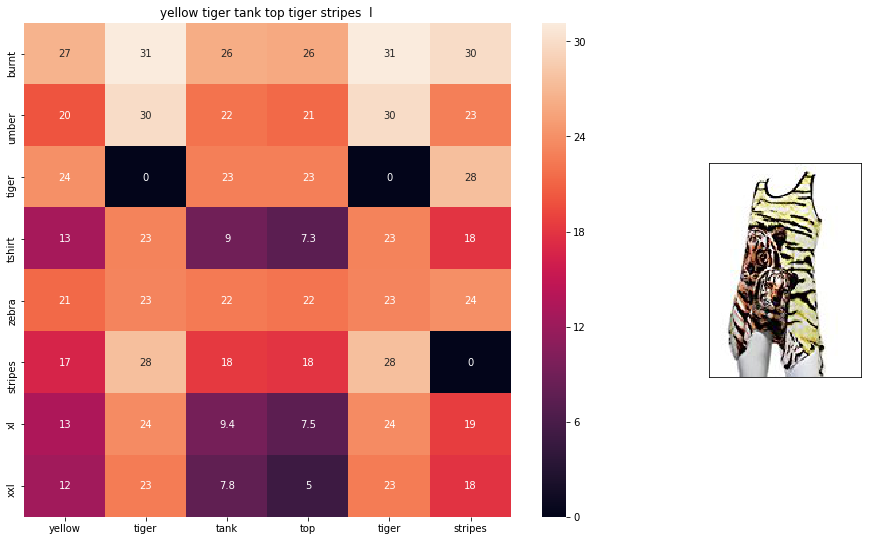

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from input : 5.6895237


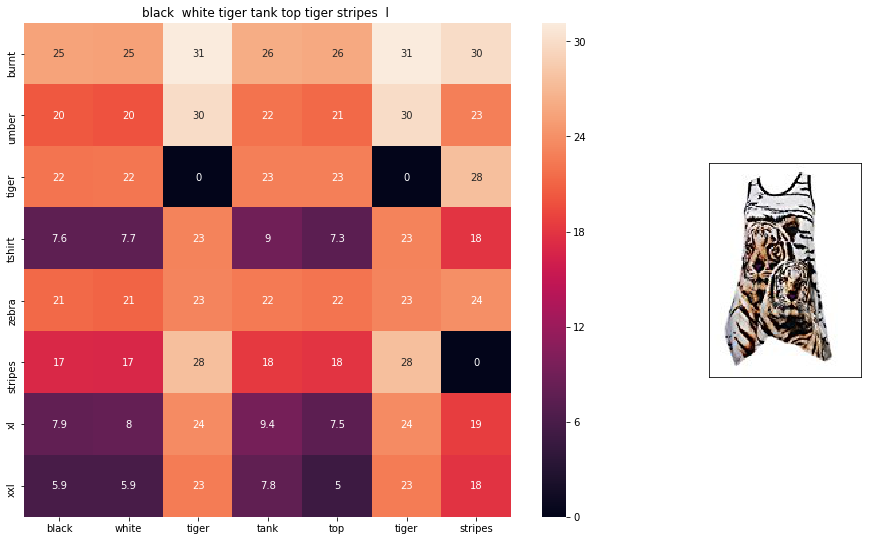

ASIN : B00JXQAO94
Brand : Si Row
euclidean distance from input : 5.6930213


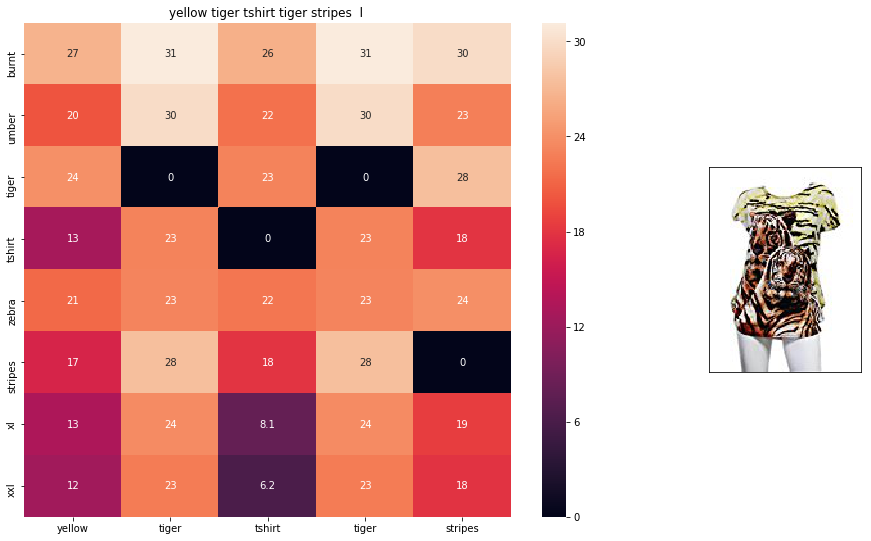

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from input : 5.8934426


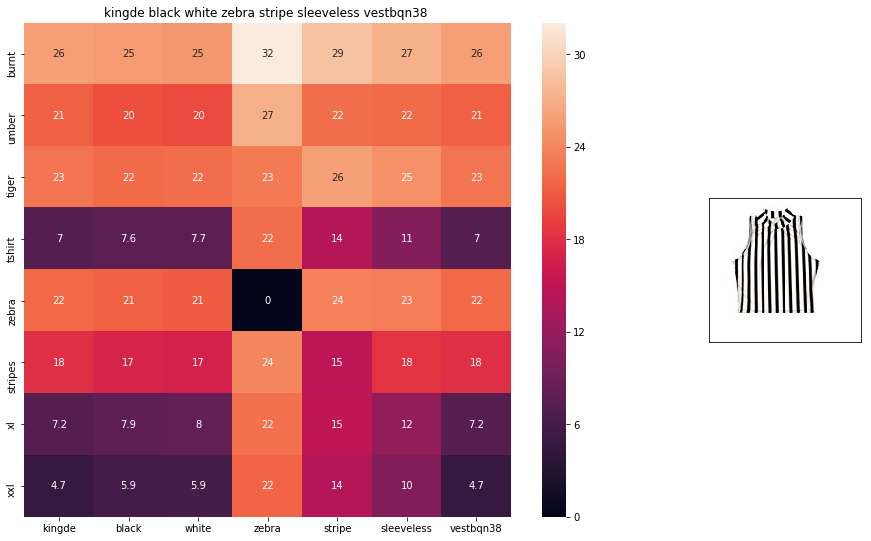

ASIN : B015H41F6G
Brand : KINGDE
euclidean distance from input : 6.13299


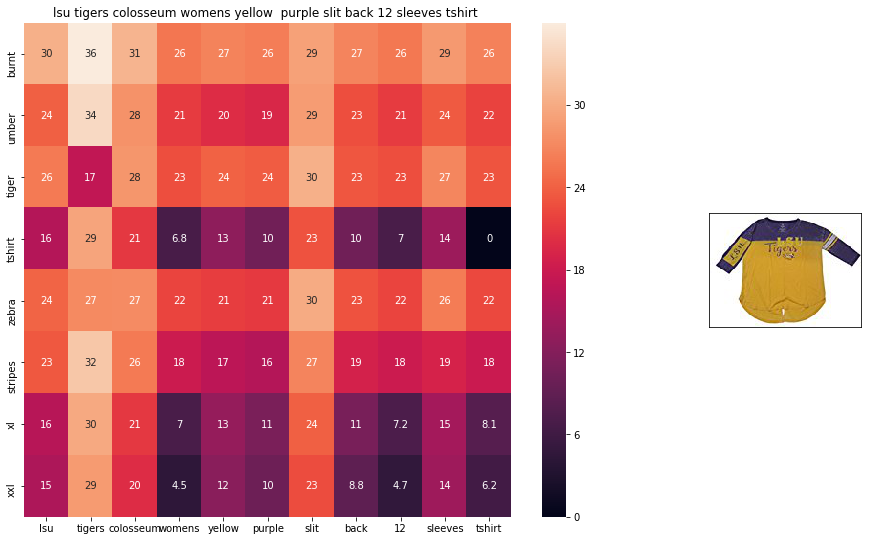

ASIN : B073R5Q8HD
Brand : Colosseum
euclidean distance from input : 6.2567067


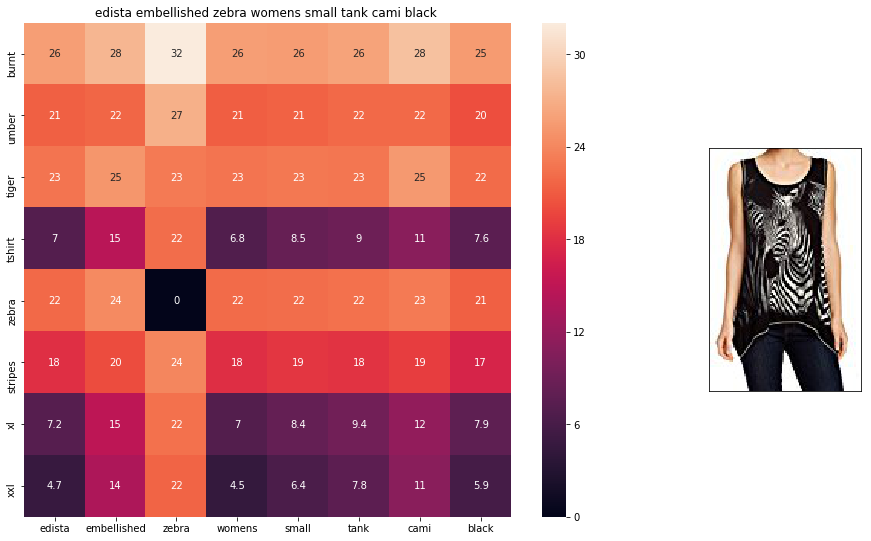

ASIN : B074P8MD22
Brand : Edista
euclidean distance from input : 6.3922043


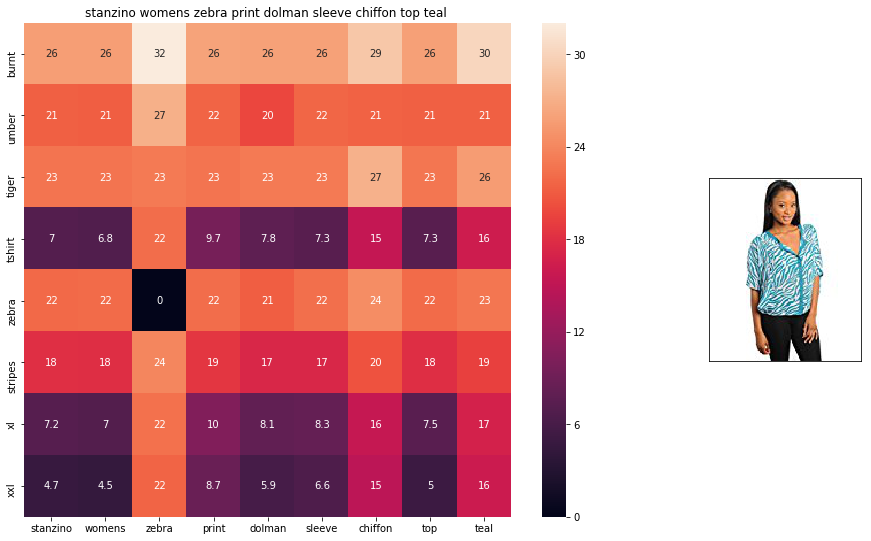

ASIN : B00C0I3U3E
Brand : Stanzino
euclidean distance from input : 6.414901


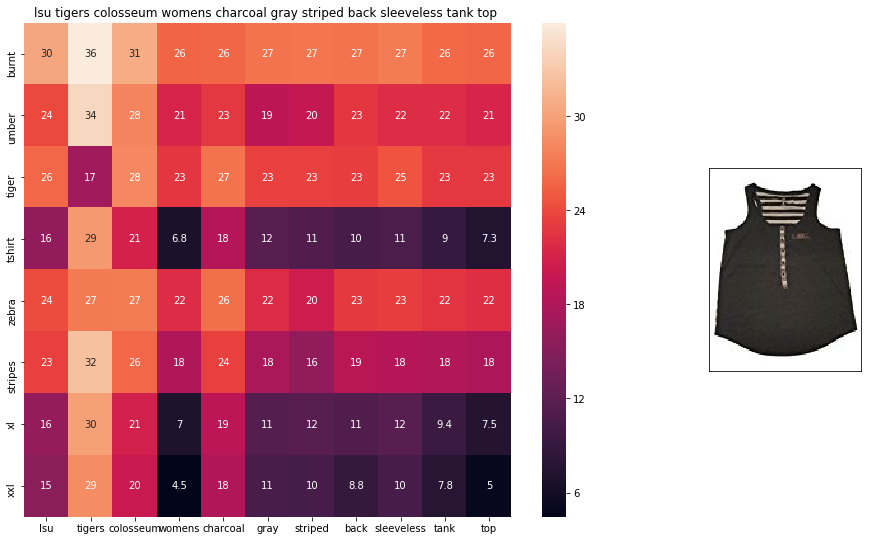

ASIN : B073R4ZM7Y
Brand : Colosseum
euclidean distance from input : 6.45096


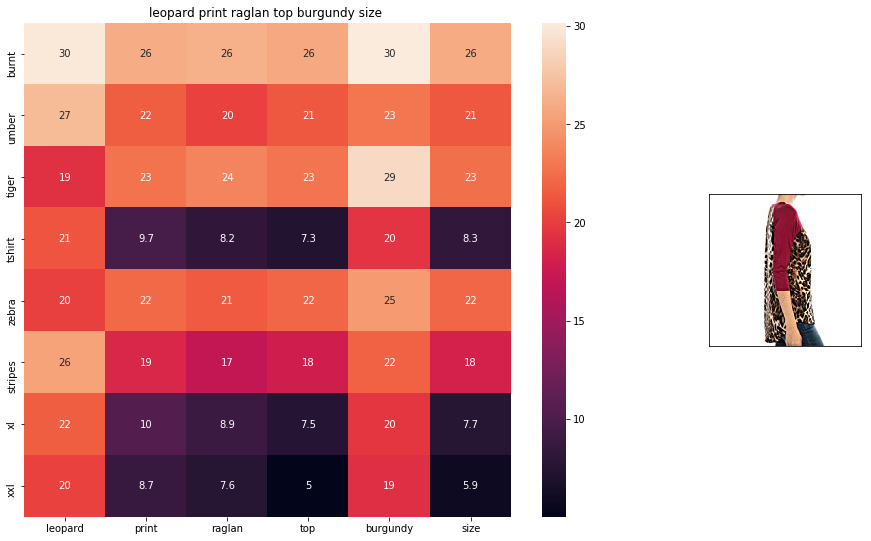

ASIN : B01C6ORLDQ
Brand : 1 Mad Fit
euclidean distance from input : 6.4634094


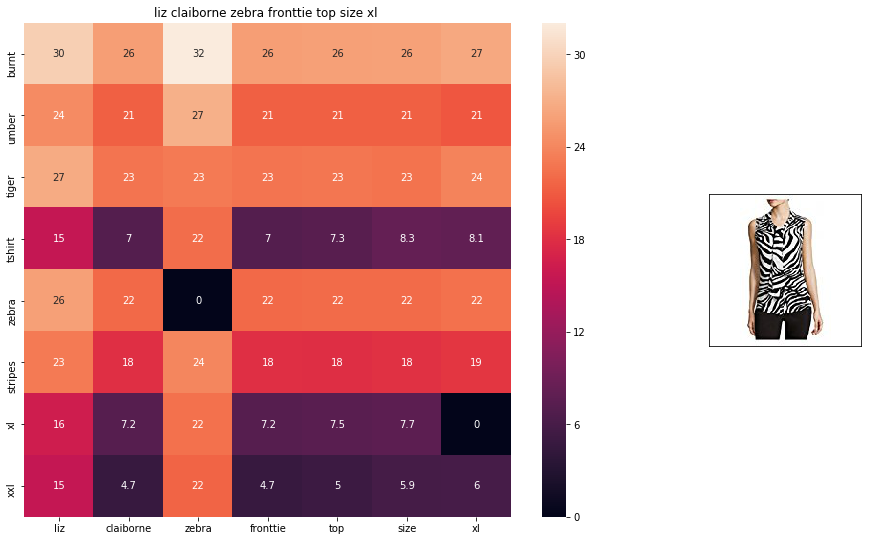

ASIN : B06XBY5QXL
Brand : Liz Claiborne
euclidean distance from input : 6.5392237


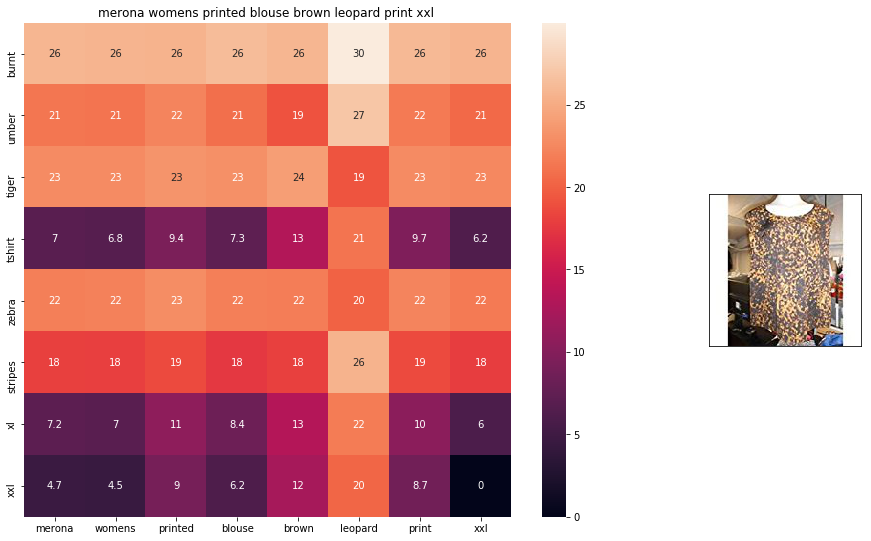

ASIN : B071YF3WDD
Brand : Merona
euclidean distance from input : 6.575504


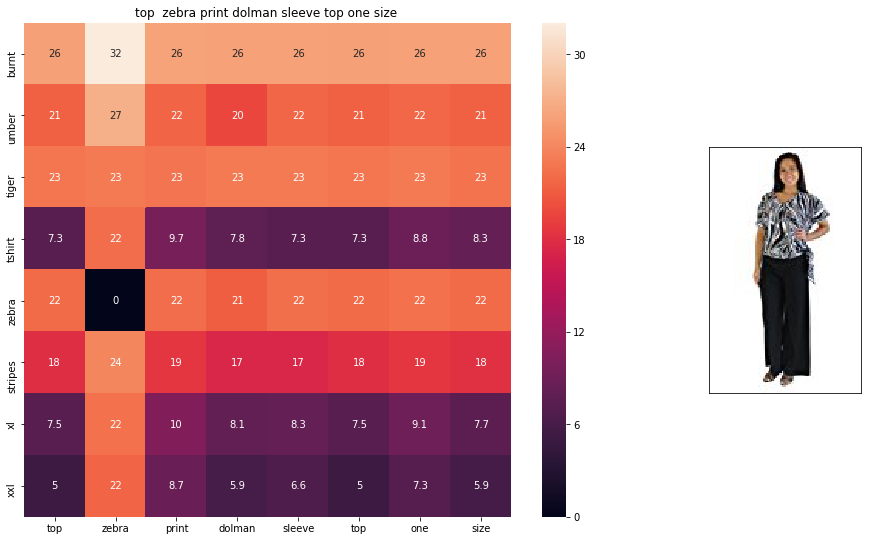

ASIN : B00H8A6ZLI
Brand : Vivian's Fashions
euclidean distance from input : 6.6382155


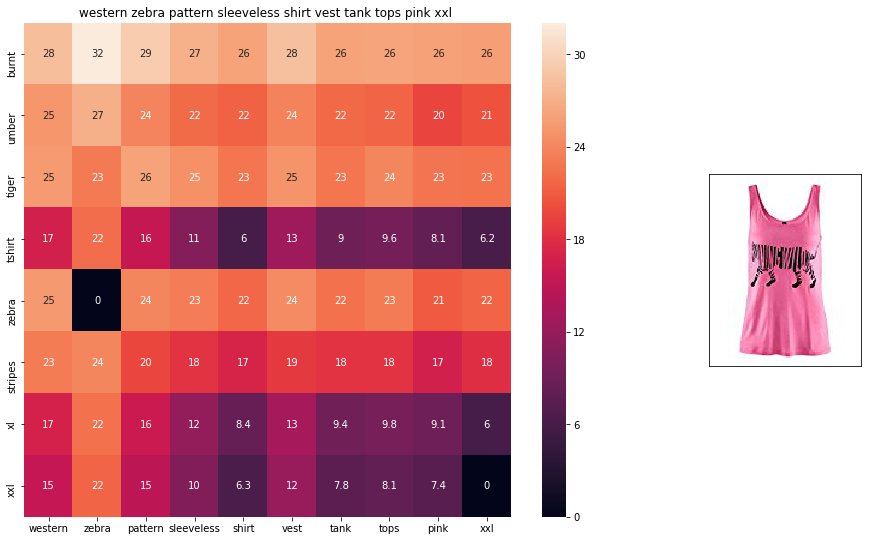

ASIN : B00Z6HEXWI
Brand : Black Temptation
euclidean distance from input : 6.660737


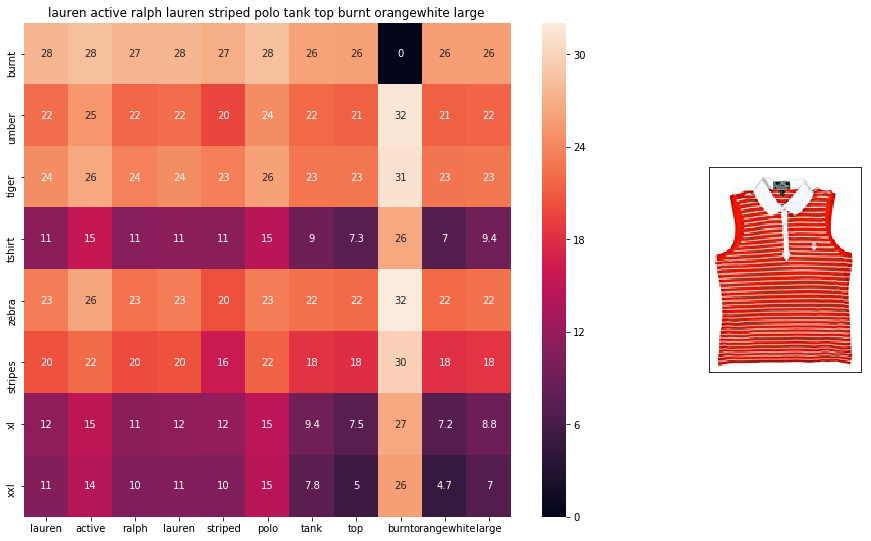

ASIN : B00ILGH5OY
Brand : Ralph Lauren Active
euclidean distance from input : 6.6839056


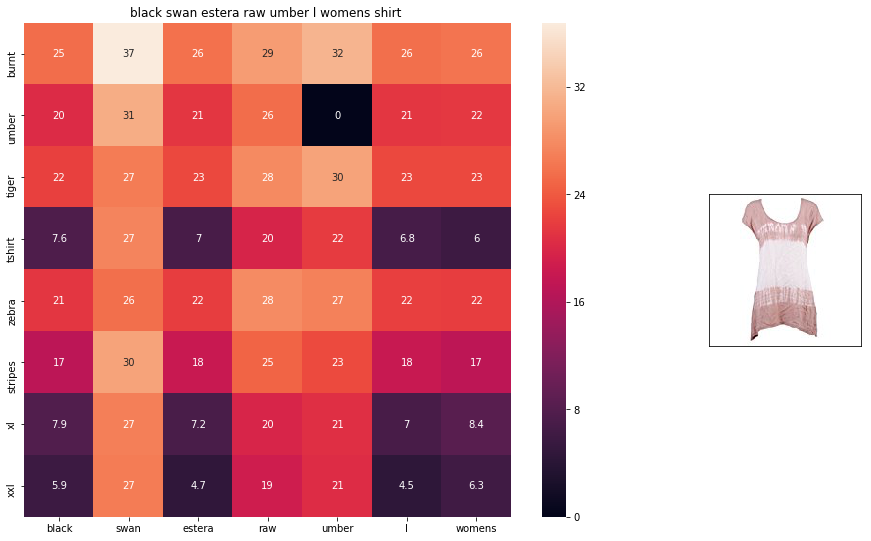

ASIN : B06Y1VN8WQ
Brand : Black Swan
euclidean distance from input : 6.7057643


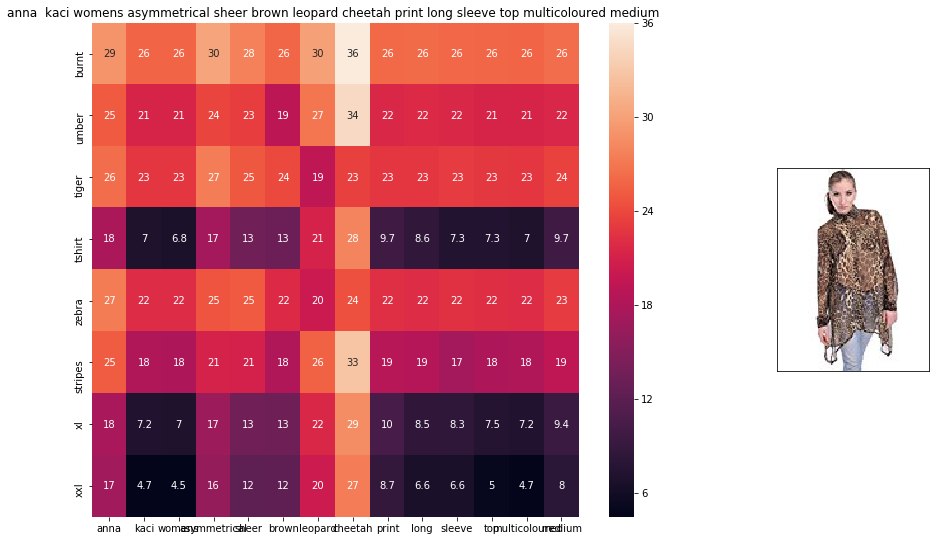

ASIN : B00KSNTY7Y
Brand : Anna-Kaci
euclidean distance from input : 6.706125


In [105]:
def weighted_w2v_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
   
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

weighted_w2v_model(12566, 20)

In [106]:
import plotly

In [107]:

data['brand'].fillna(value="Not given", inplace=True )

brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [108]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
   
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
   
    plotly.offline.iplot(table, filename='simple_table')
    
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    ax1 = plt.subplot(gs[:, :-5])
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    ax1.set_xticklabels(sentance2.split())
    ax1.set_yticklabels(sentance1.split())
    ax1.set_title(sentance2)

    ax2 = plt.subplot(gs[:, 10:16])
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    display_img(url, ax2, fig)
    
    plt.show()

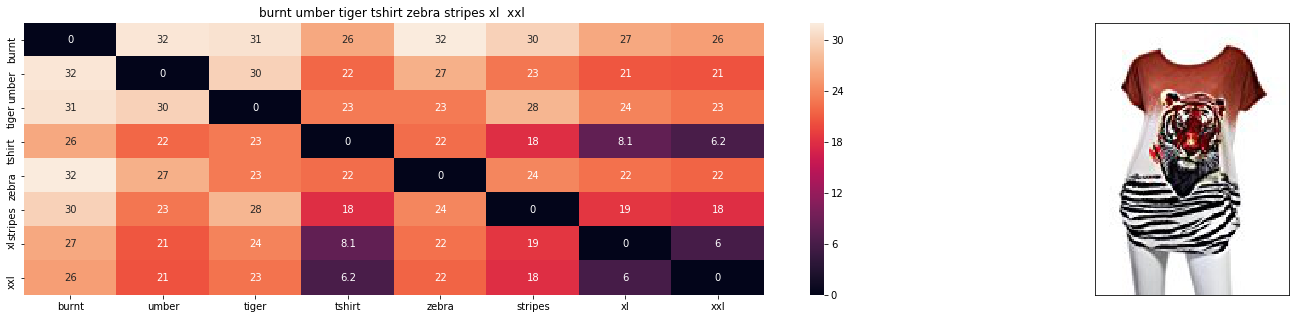

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.001953125


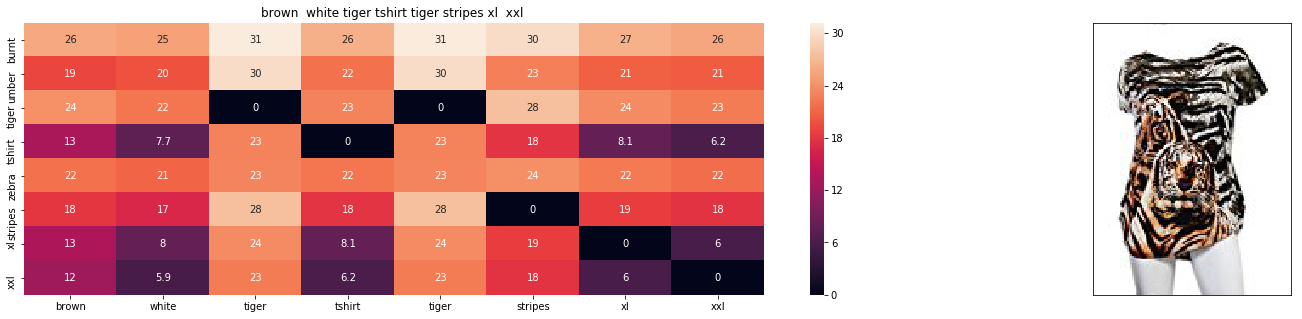

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from input : 2.385471153259277


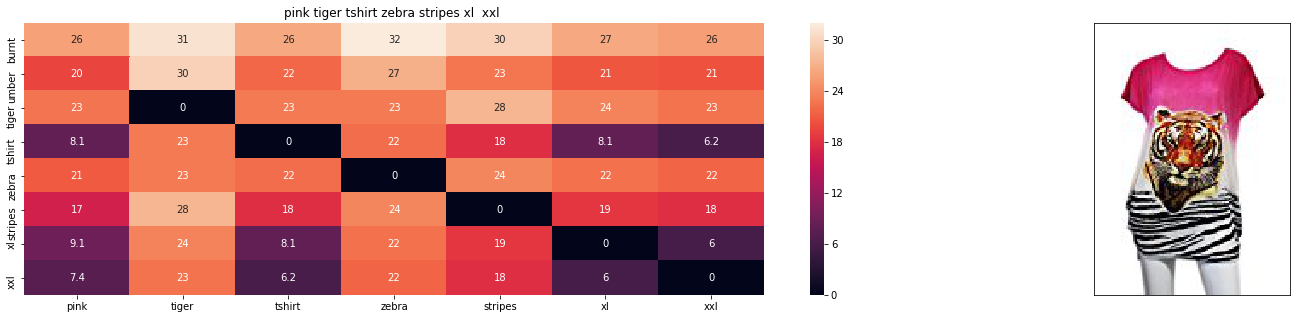

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from input : 2.739051056088891


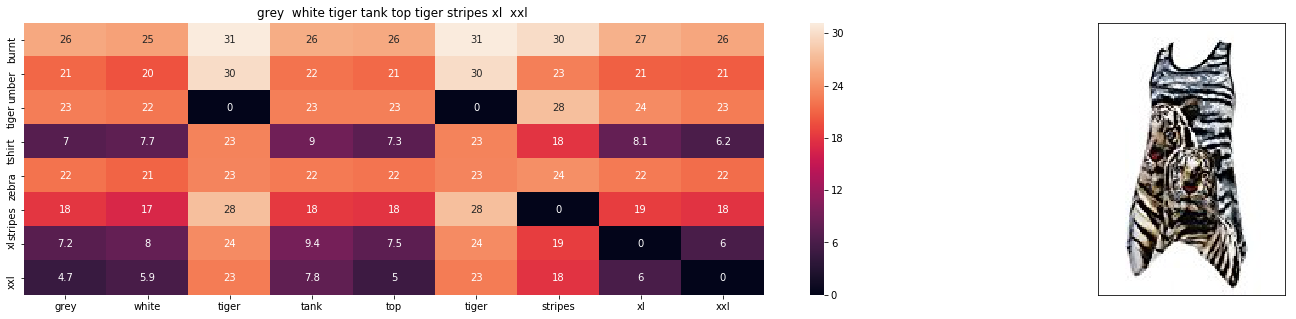

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from input : 3.387187195004907


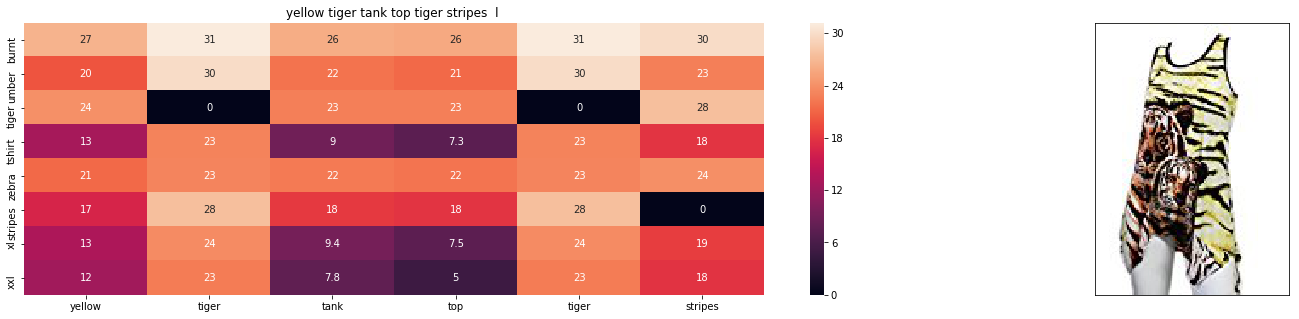

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from input : 3.5518686296362545


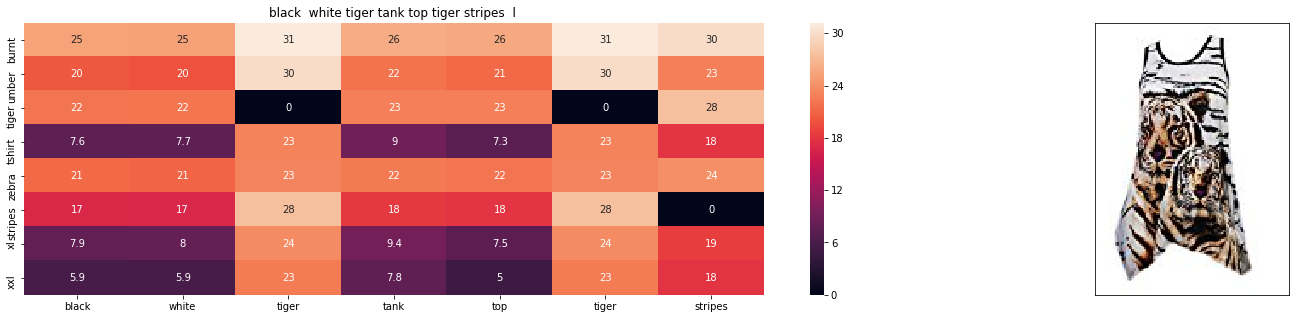

ASIN : B00JXQAO94
Brand : Si Row
euclidean distance from input : 3.5536174775976805


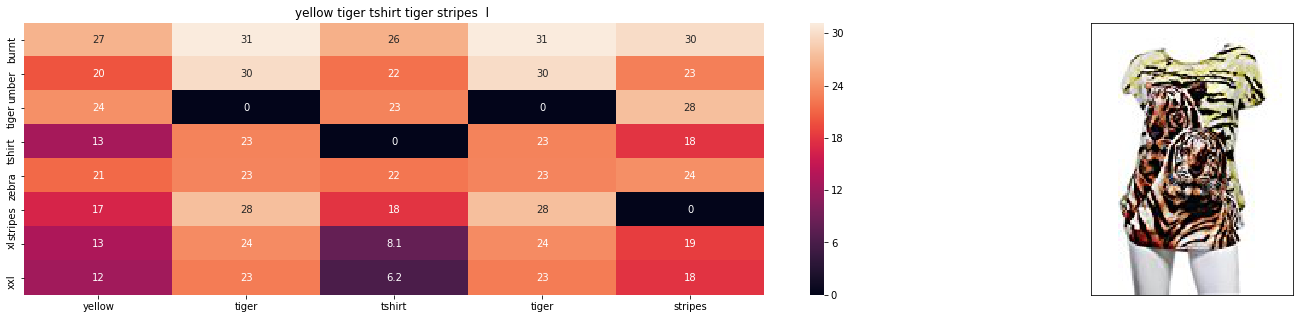

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from input : 3.653828048886743


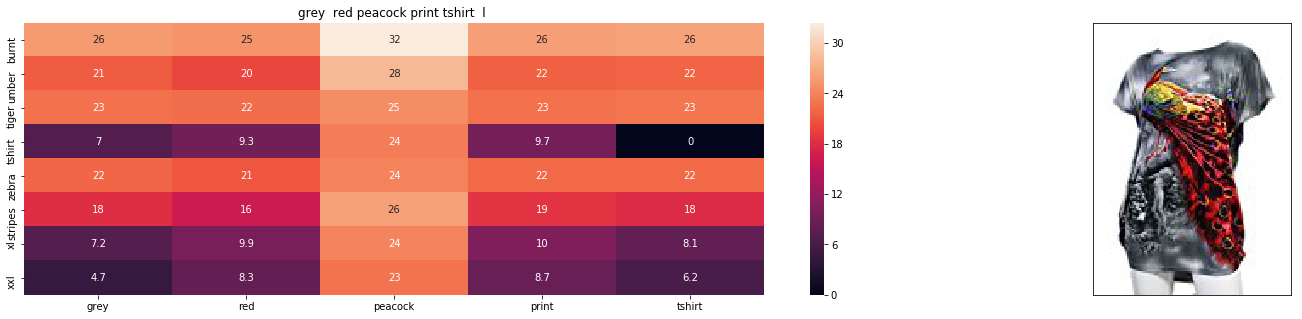

ASIN : B00JXQCFRS
Brand : Si Row
euclidean distance from input : 4.128811645688501


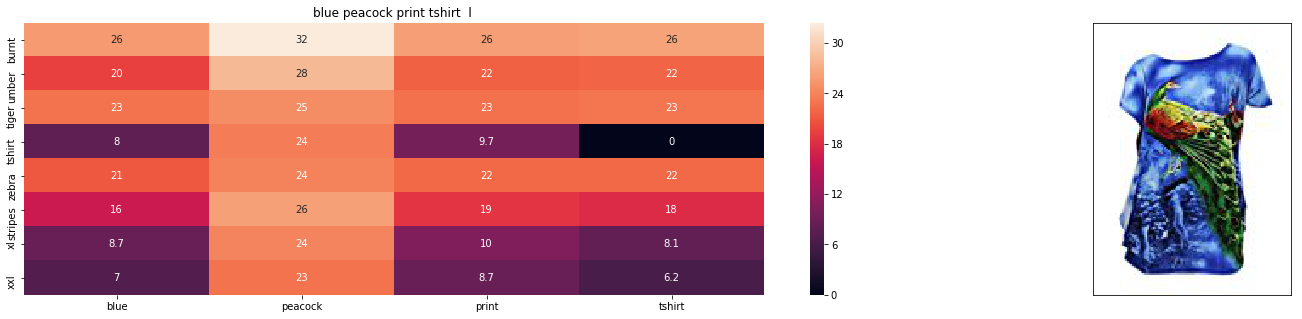

ASIN : B00JXQC8L6
Brand : Si Row
euclidean distance from input : 4.203900146665063


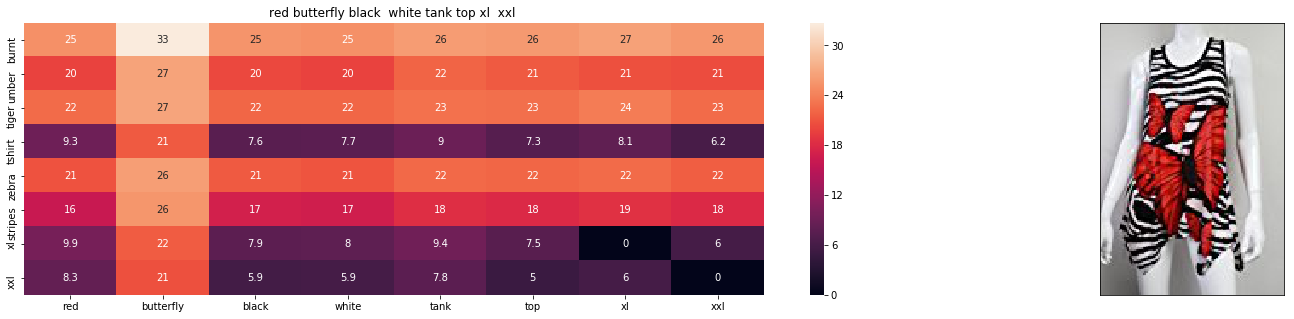

ASIN : B00JV63CW2
Brand : Si Row
euclidean distance from input : 4.286586761655298


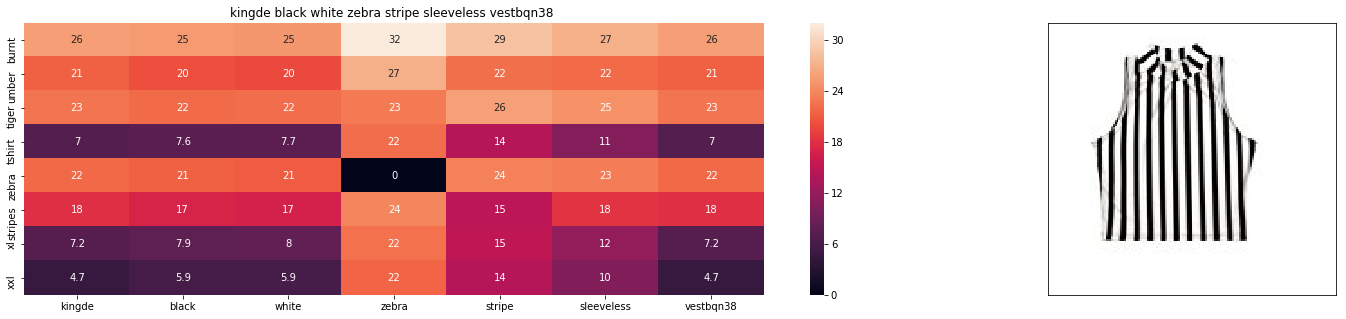

ASIN : B015H41F6G
Brand : KINGDE
euclidean distance from input : 4.389370597243721


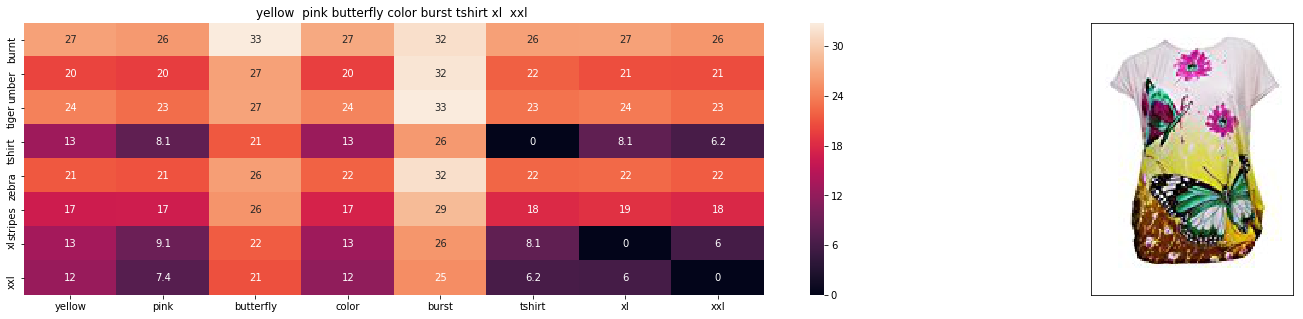

ASIN : B00JXQBBMI
Brand : Si Row
euclidean distance from input : 4.397910309018579


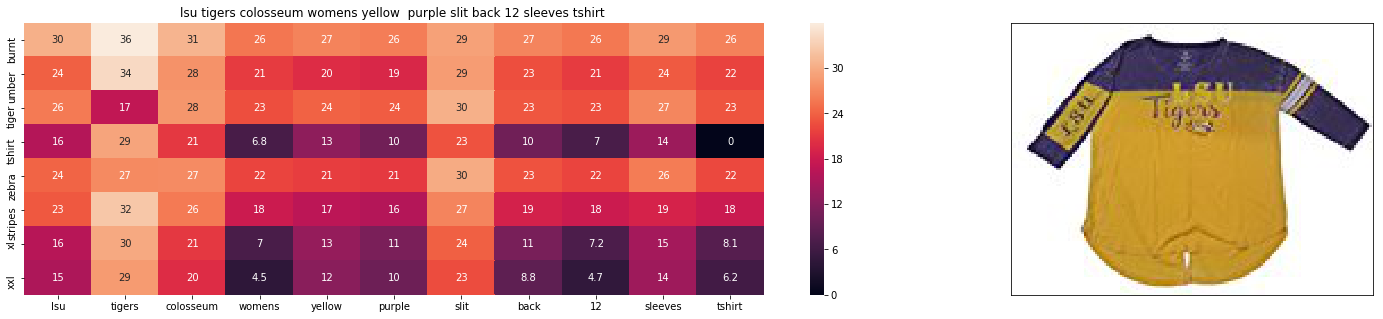

ASIN : B073R5Q8HD
Brand : Colosseum
euclidean distance from input : 4.451228965163643


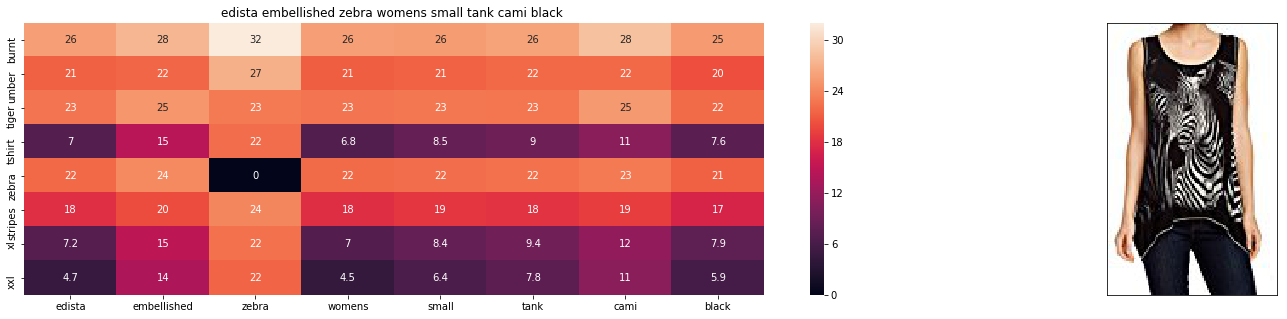

ASIN : B074P8MD22
Brand : Edista
euclidean distance from input : 4.518977797866279


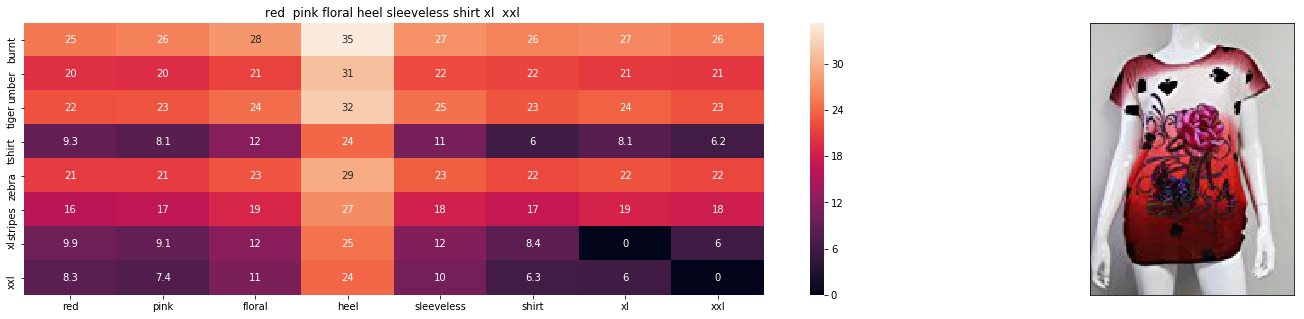

ASIN : B00JV63QQE
Brand : Si Row
euclidean distance from input : 4.529375076474634


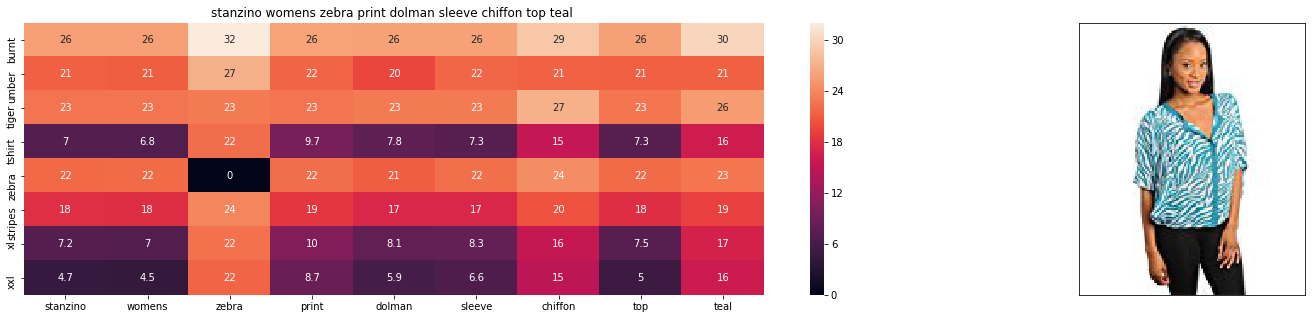

ASIN : B00C0I3U3E
Brand : Stanzino
euclidean distance from input : 4.530326140761788


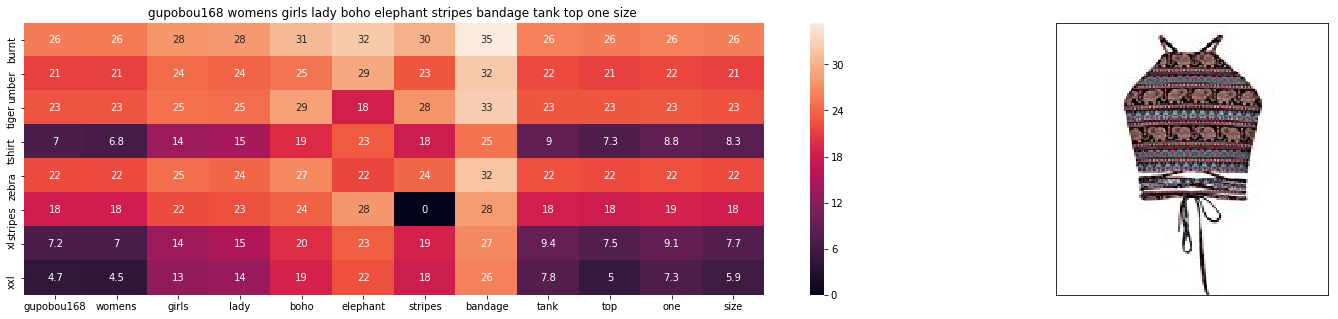

ASIN : B01ER184O6
Brand : GuPoBoU168
euclidean distance from input : 4.546817024028215


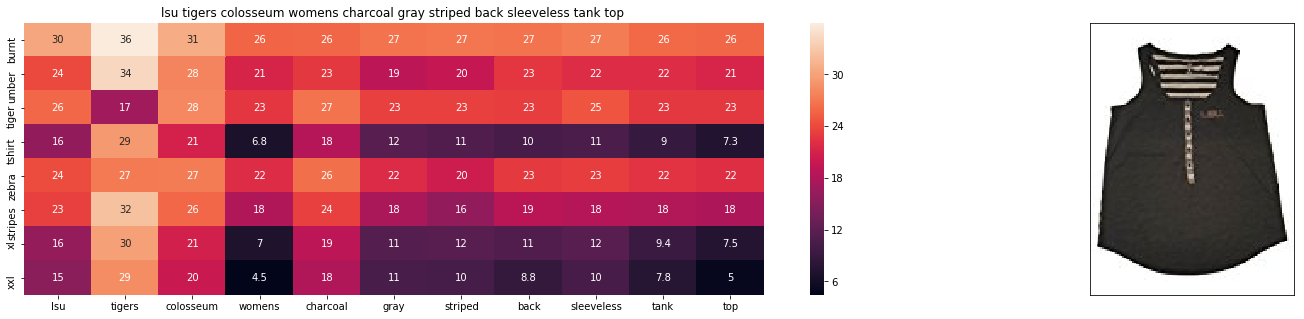

ASIN : B073R4ZM7Y
Brand : Colosseum
euclidean distance from input : 4.548355544448311


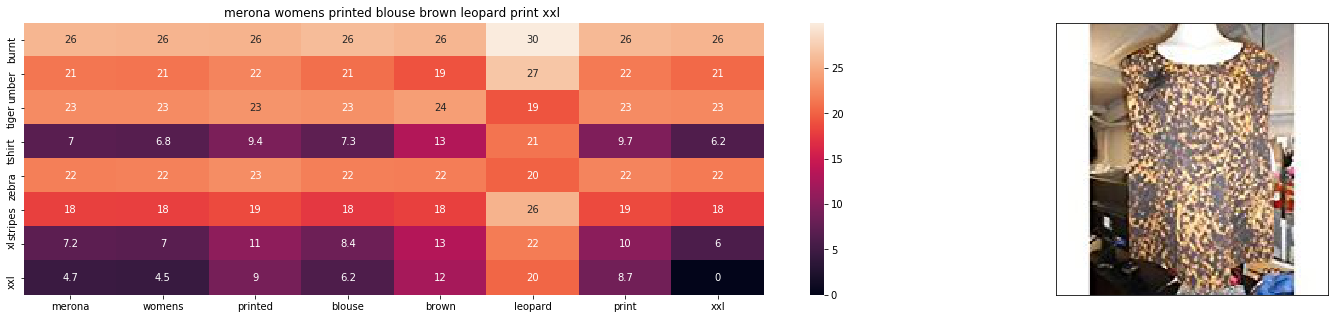

ASIN : B071YF3WDD
Brand : Merona
euclidean distance from input : 4.610627425551827


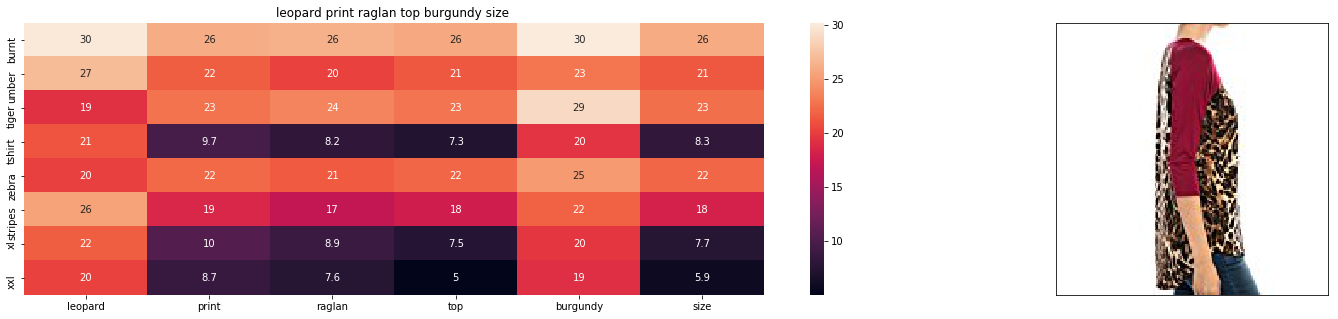

ASIN : B01C6ORLDQ
Brand : 1 Mad Fit
euclidean distance from input : 4.645918274287157


In [109]:
def idf_w2v_brand(doc_id, w1, w2, num_results):
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist)/float(w1 + w2)

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

idf_w2v_brand(12566, 5, 5, 20)